# Inventory scores and metal futures returns

This notebook illustrates the points discussed in the post “Inventory scores and metal futures returns”,  available on the Macrosynergy website.

Inventory scores are quantamental (point-in-time) indicators of the inventory states and dynamics of economies or commodity sectors. Inventory scores plausibly predict base metal futures returns through two effects. First, they influence the convenience yield of a metal and the discount at which futures are trading relative to physical stock. Second, they indicate the need for restocking at the raw material and finished goods side. Inventory scores are available for finished manufacturing goods and base metals themselves. Empirical analysis for 2000-2024 shows strong predictive power of finished goods inventory scores and some modest additional predictive power of commodity-specific inventory scores.

This notebook provides the essential code required to replicate the analysis discussed in the post.

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis.

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including normalisation or building simple linear composite indicators.

- Value checks: This is the most critical section, where the notebook calculates and implements the simple trading strategy based on the hypothesis tested in the post. This section involves backtesting simple trading strategies. In particular, the post investigates the predictive relationship of manufacturing inventory assessment scores on metal futures returns.

It is important to note that while the notebook covers a selection of indicators and strategies used for the post’s main findings, users can explore countless other possible indicators and approaches. Users can modify the code to test different hypotheses and strategies based on their research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

In [1]:
# Run only if needed! The cell upgrades macrosynergy package to the latest version
"""
%%capture
! pip install macrosynergy --upgrade"""

'\n%%capture\n! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload


import warnings
warnings.simplefilter("ignore")

This notebook downloads selected indicators for the following cross-sections: AUD (Australian dollar), BRL (Brazilian real), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), CNY (Chinese yuan), COP (Colombian Peso), CZK (Czech koruna), EUR (euro), GBP (British pound), HKD (Hong Kong dollar), HUF (Hungarian forint), IDR (Indonesian rupiah), ILS (Israeli shekels), INR (Indian rupee), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), MYR (Malaysian ringgit), NOK (Norwegian Krone), NZD (New Zealand dollar), PEN (Peruvian sol), PHP (Philippine peso), PLN (Polish złoty), RON (Romanian leu), RUB (Russian ruble), SGD (Singapore dollar), SEK (Swedish krona), THB (Thai baht), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar), ZAR (South African rand). For convenience purposes, the cross-sections are collected in a few lists, such as Developed markets large currencies ("EUR", "JPY", "USD"), emerging markets latam ("BRL", "COP", "CLP", "MXN", "PEN"), etc. In addition, the notebook downloads Directional risk basket returns for GLB (global directional risk basket) and for global equity index future basket (GEQ). For weigting and explanations please see [here](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Directional%20risk%20basket%20returns.php)

The notebook downloads the following JPMaQS categories:  [Commodity inventories](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/Commodity%20inventories.php) for the following metals: 
- `ALM`: Aluminium
- `CPR`: Copper
- `LED`: Lead
- `NIC`: Nickel
- `TIN` : London Metal Exchange Tin
- `ZNC`: Zinc

The notebook also uses the following categories:
 [Manufacturing confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Manufacturing%20confidence%20scores.php), [Global production shares](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php), [Directional risk basket returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Directional%20risk%20basket%20returns.php), [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php), and [Commodity future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php#).

In [3]:
cids_bam = ["ALM", "CPR", "LED", "NIC", "TIN", "ZNC"]
cids_lme = list(set(cids_bam) - set(["TIN"]))  # metals with LME inventory data

minvs = [
    "XINVSCORELME_SA",
    "XINVSCORELME_SA_3MMA",
    "XINVSCORELME_SA_D3M3ML3",
    "XINVSCORELME_SA_D6M6ML6",
    "XINVSCORELME_SA_3MMA_D1M1ML12",
]
mrets = ["COXR_VT10", "COXR_NSA", "COCRR_NSA", "COCRR_VT10"]

xcats_bam = minvs + mrets
tix_bam = [cid + "_" + xcat for cid in cids_bam for xcat in xcats_bam]

In [4]:
cids_dmlc = ["EUR", "JPY", "USD"]  # DM large currency areas
cids_dmsc = ["AUD", "CAD", "CHF", "GBP", "NOK", "NZD", "SEK"]  # DM small currency areas
cids_latm = ["BRL", "COP", "CLP", "MXN", "PEN"]  # Latam
cids_emea = ["CZK", "HUF", "ILS", "PLN", "RON", "RUB", "TRY", "ZAR"]  # EMEA
cids_emas = ["IDR", "INR", "KRW", "MYR", "PHP", "THB", "TWD"]  # EM Asia flex
cids_apeg = ["CNY", "HKD", "SGD"]  # EM Asia peg

cids = cids_dmlc + cids_dmsc + cids_latm + cids_emea + cids_emas + cids_apeg

invs = [
    "MBISCORE_SA",
    "MBISCORE_SA_3MMA",
    "MBISCORE_SA_D1M1ML1",
    "MBISCORE_SA_D3M3ML3",
    "MBISCORE_SA_D1Q1QL1",
    "MBISCORE_SA_D6M6ML6",
    "MBISCORE_SA_D2Q2QL2",
    "MBISCORE_SA_3MMA_D1M1ML12",
    "MBISCORE_SA_D1Q1QL4",
]

econ = ["IVAWGT_SA_1YMA", "IVAWGT_SA_3YMA", "GB05YXR_NSA"]

xcats = invs + econ

tix_invs = [cid + "_" + xcat for cid in cids for xcat in xcats]

In [5]:
# Complete ticker list

tix_add = ["GLB_DRBXR_NSA", "GEQ_DRBXR_NSA", "USD_EQXR_NSA"]
tickers = tix_bam + tix_invs + tix_add

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [6]:
# Download series from J.P. Morgan DataQuery by tickers. to speed up running time, only using 3 years

start_date = "1995-01-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        suppress_warning=True,
        metrics=["value"],
        report_time_taken=True,
        show_progress=True,
    )

Timestamp UTC:  2024-05-03 14:41:29
Connection successful!


Requesting data: 100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


Time taken to download data: 	14.83 seconds.
Some expressions are missing from the downloaded data. Check logger output for complete list.
188 out of 453 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
7657 out of 7657 dates are missing.


In [7]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])

### Renaming and availability

Rename quarterly tickers to roughly equivalent monthly tickers to simplify subsequent operations.

In [8]:
dict_repl = {
    "MBISCORE_SA_D1Q1QL1": "MBISCORE_SA_D3M3ML3",
    "MBISCORE_SA_D2Q2QL2": "MBISCORE_SA_D6M6ML6",
    "MBISCORE_SA_D1Q1QL4": "MBISCORE_SA_3MMA_D1M1ML12",
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

It is important to assess data availability before conducting any analysis. It allows for the identification of any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available, as well as determining the appropriate time periods for analysis. 

[check_availability()](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#view-available-data-history-with-check-availability) functions list visualizes start years and the number of missing values at or before the end date of all selected cross-sections and across a list of categories. It also displays unavailable indicators as gray fields and color codes for the starting year of each series, with darker colors indicating more recent starting years. 

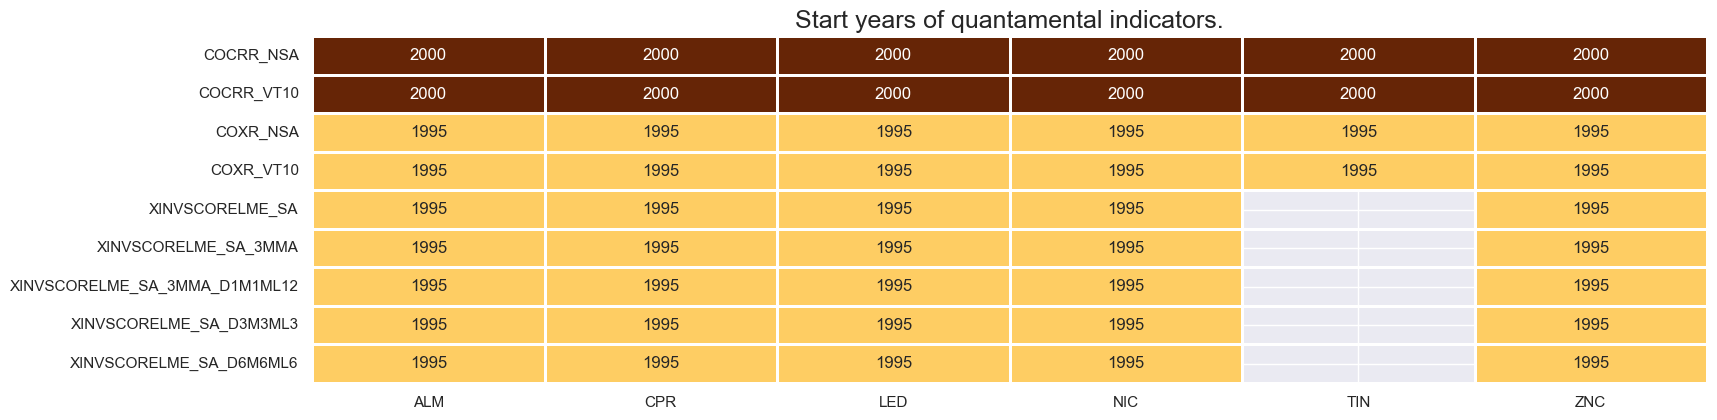

In [9]:
msm.check_availability(df, xcats=xcats_bam, cids=cids_bam, missing_recent=False)

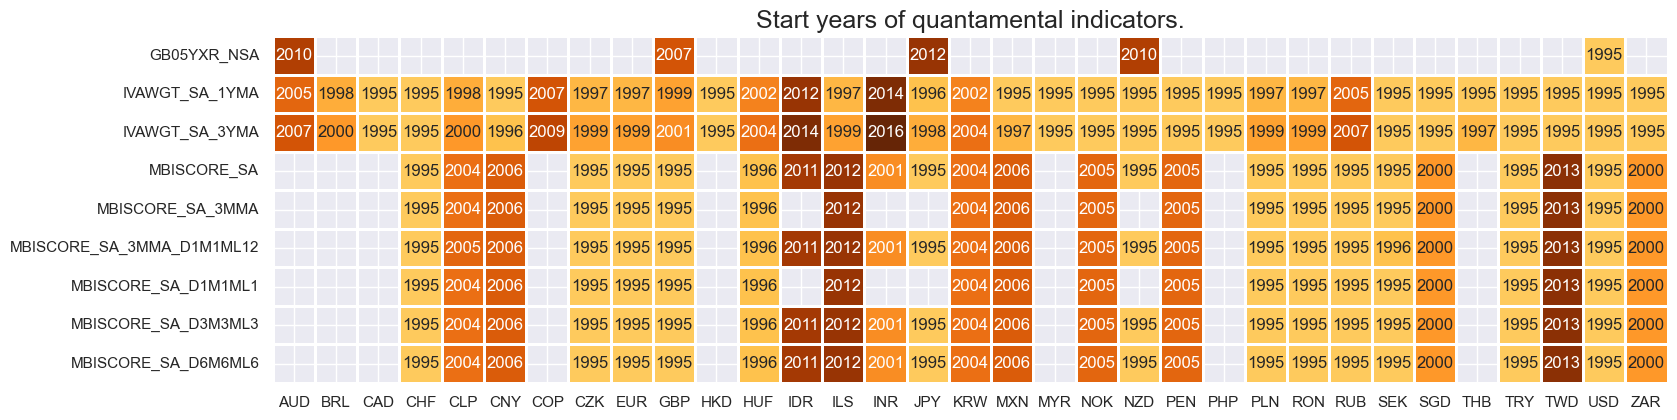

In [10]:
msm.check_availability(dfx, xcats=xcats, cids=cids, missing_recent=False)

## Transformation and checks

### Global finished goods inventory scores

The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the `macrosynergy` package, is employed to aggregate each individual category score across markets into a unified composite indicator with new currency identifier `GMB` (Global metal basket). This method offers the flexibility to assign specific weights to each market, which can vary over time. In this instance, we use as weights respective global production shares for all available emerging and developed markets based on a 1-year moving average (`IVAWGT_SA_1YMA`). The outcome is a new weighted time series uniquely identified by the cross-section GMB. This methodological approach ensures that each market contributes proportionally to the composite measure. This process is repeated for all selected indicators collected in the list `iscores`.

In [11]:
iscores = [
    "MBISCORE_SA_3MMA",
    "MBISCORE_SA_3MMA_D1M1ML12",
    "MBISCORE_SA_D3M3ML3",
    "MBISCORE_SA_D6M6ML6",
]
xcatx = iscores

# creating the linear composite for each of the Manufacturing categories

for xc in xcatx:
    dfa = msp.linear_composite(
        df=dfx,
        xcats=xc,
        cids=cids,
        weights="IVAWGT_SA_1YMA",
        new_cid="GMB",
        complete_cids=False,
    )
    dfx = msm.update_df(dfx, dfa)

[`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package is used to plot the timeline of the resulting weighted global manufacturing inventory assessment score, 3-month moving average `MBISCORE_SA_3MMA`:

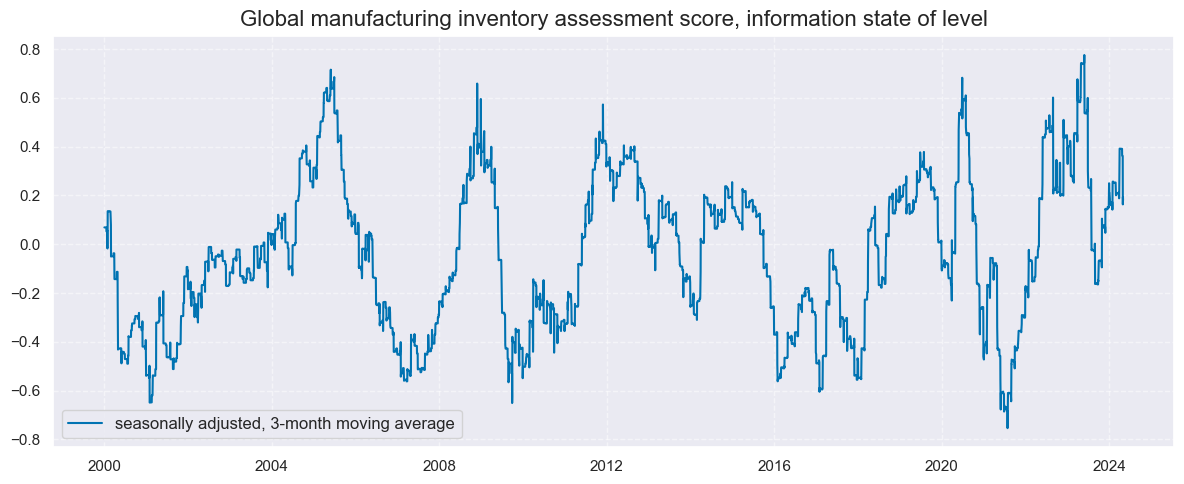

In [12]:
xcatx = ["MBISCORE_SA_3MMA"]

msp.view_timelines(
    dfx,
    cids="GMB",
    xcats=xcatx,
    title="Global manufacturing inventory assessment score, information state of level",
    title_fontsize=16,
    xcat_labels=["seasonally adjusted, 3-month moving average"],
    size=(12, 5),
)

[`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package is used to compare the timelines of information states of changes for global weighted indicators:

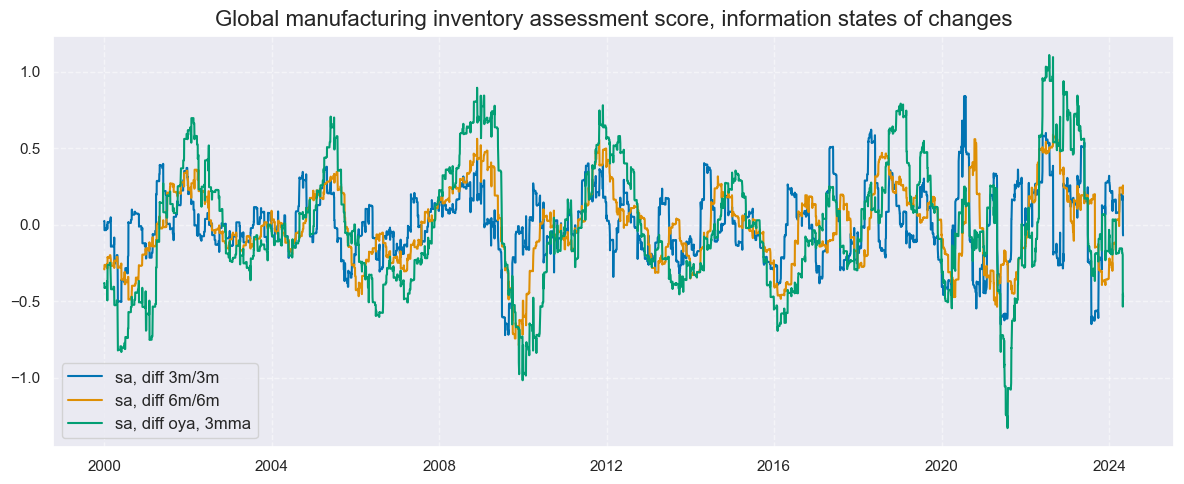

In [13]:
xcatx = [
    "MBISCORE_SA_D3M3ML3",
    "MBISCORE_SA_D6M6ML6",
    "MBISCORE_SA_3MMA_D1M1ML12",
]

msp.view_timelines(
    dfx,
    cids="GMB",
    xcats=xcatx,
    title="Global manufacturing inventory assessment score, information states of changes",
    title_fontsize=16,
    xcat_labels=["sa, diff 3m/3m",
                 "sa, diff 6m/6m",
                 "sa, diff oya, 3mma"],
    size=(12, 5),
)

The following cell populates the columns "MBISCORE_SA_3MMA", "MBISCORE_SA_3MMA_D1M1ML12", "MBISCORE_SA_D3M3ML3", and "MBISCORE_SA_D6M6ML6" for metal contracts. It essentially replicates the values from the respective weighted baskets and assigns them to their corresponding contracts.

In [14]:
calcs = []
for xc in iscores:
    calcs += [f"{xc} = iGMB_{xc}"]  # pseudo commodity indicators 

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_bam)
dfx = msm.update_df(dfx, dfa)


### Metals basket inventories (and returns)

Commodity basket returns are calculated as equally weighted vol target-adjusted positions with help `macrosynergy` [`basket`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#generate-returns-and-carry-of-a-group-of-contracts-with-basket) class

In [15]:
cos = [cid + "_CO" for cid in cids_bam]
dfa = pd.DataFrame(columns=dfx.columns)

for ad in ["NSA", "VT10"]:
    mb = msp.Basket(
        dfx,
        contracts=cos,
        ret="XR_" + ad,
        cry="CRR_" + ad,
    )
    mb.make_basket(weight_meth="equal", basket_name="GMB")  # each base metal has same weight in the basket
    dfaa = mb.return_basket().sort_values(["cid", "xcat", "real_date"])
    dfa = msm.update_df(dfa, dfaa)


The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the macrosynergy package is utilized to merge individual category scores from multiple markets into a unified composite indicator, designated by the cross-section identifier `GMB` (Global metal basket).

In [16]:
xcatx = minvs + mrets
cidx = cids_lme

for xc in xcatx:
    dfa = msp.linear_composite(
        df=dfx,
        xcats=xc,
        cids=cidx,
        new_cid="GMB",
        complete_cids=False,
    )
    dfx = msm.update_df(dfx, dfa)

In the following plot, we review the normalized global timelines for key metrics: Excess Commodity Inventories related to the London Metal Exchange, seasonally adjusted and transformed into a 3-month moving average z-score, alongside Manufacturing inventory assessment score, also seasonally adjusted and converted into a 3-month moving average z-score.

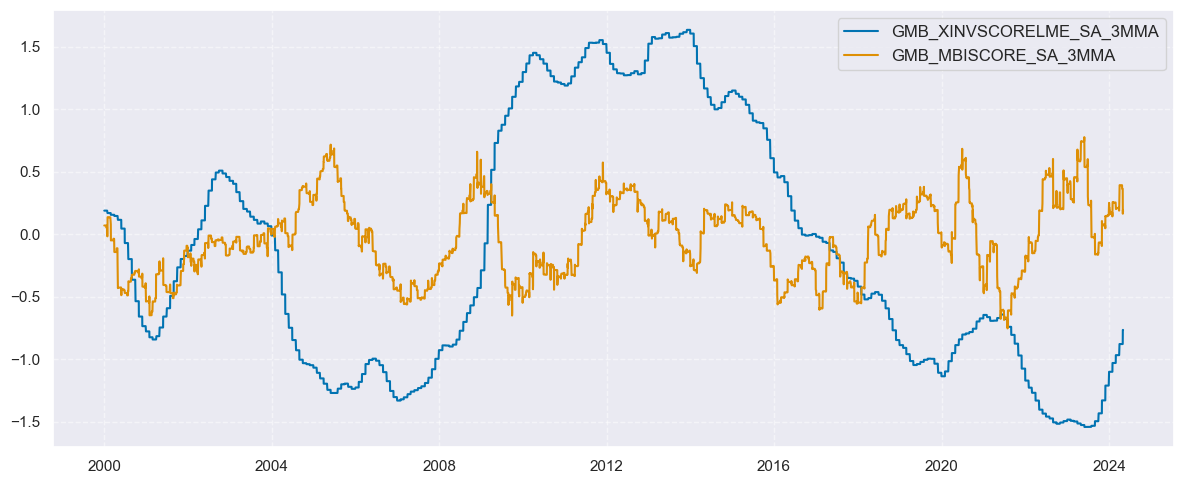

In [17]:
xcatx = ["XINVSCORELME_SA_3MMA", "MBISCORE_SA_3MMA"]

msp.view_timelines(
    dfx,
    cids="GMB",
    xcats=xcatx,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)

In this plot, we examine the normalized global timelines for the six-month changes (diff 6m/6m) in the same indicators as above: Excess Commodity Inventories linked to the London Metal Exchange, which are seasonally adjusted, and Manufacturing inventory assessment score, similarly seasonally adjusted and converted into a 6-month moving average z-score.

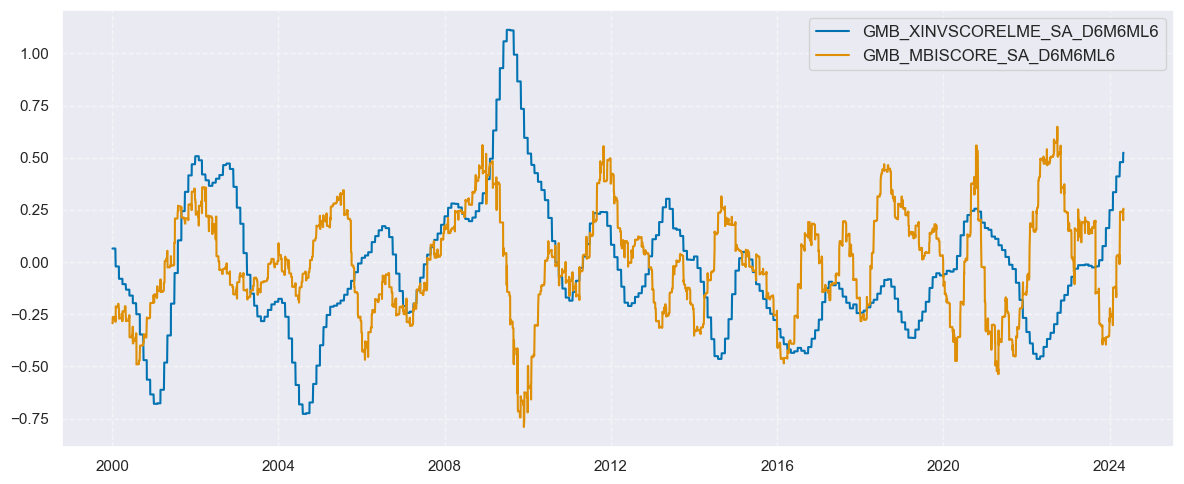

In [18]:
xcatx = ["XINVSCORELME_SA_D6M6ML6", "MBISCORE_SA_D6M6ML6"]

msp.view_timelines(
    dfx,
    cids="GMB",
    xcats=xcatx,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)


In this plot, we analyze two cumulative outright global commodity returns: `COXR_VT10` representing commodity future returns as a percentage of notional, and `COXR_VT10_10`, indicating commodity future returns adjusted for a 10% volatility target for the global metal basket (`GMB`)

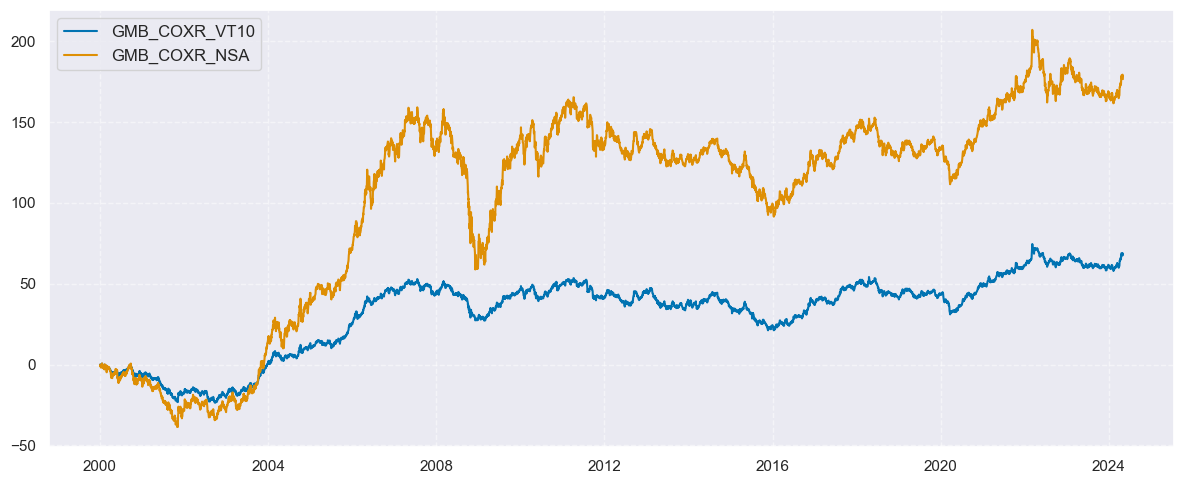

In [19]:
xcatx = ["COXR_VT10", "COXR_NSA"]

msp.view_timelines(
    dfx,
    cids="GMB",
    xcats=xcatx,
    cumsum = True,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)

### Metals-specific features


The displayed panel examines excess commodity inventories, seasonally adjusted, presented as a z-score with a 3-month moving average (`XINVSCORELME_SA_3MMA`), alongside Manufacturing inventory assessment scores, also seasonally adjusted and depicted as a z-score with a 3-month moving average (`MBISCORE_SA_3MMA`). This analysis is conducted for individual London Metal Exchange metals as well as for the basket.

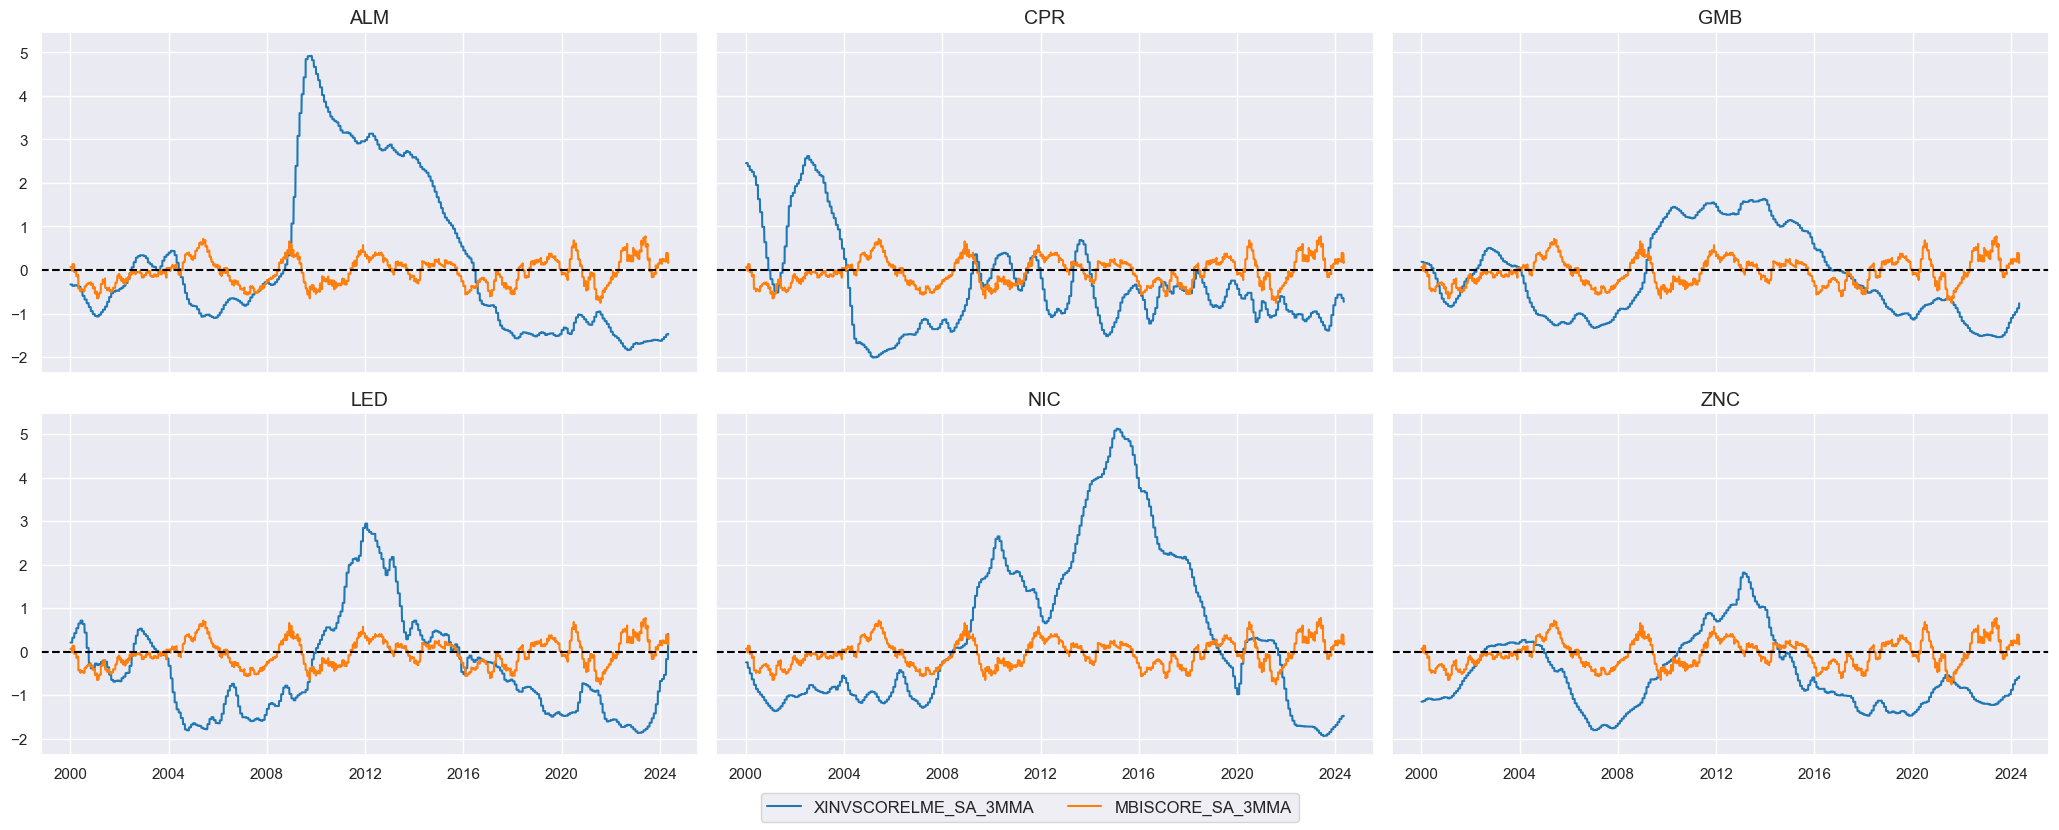

In [20]:

cids_lmx = cids_lme + ["GMB"]  # operations should include the metals basket
xcatx = ["XINVSCORELME_SA_3MMA", "MBISCORE_SA_3MMA"]

msp.view_timelines(
    dfx,
    cids=cids_lmx,
    xcats=xcatx,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)

In the forthcoming plot, we examine the normalized global timelines for the six-month changes (diff 6m/6m) in two key indicators: Excess Commodity Inventories associated with the London Metal Exchange, seasonally adjusted, and Manufacturing inventory assessment scores, similarly seasonally adjusted, with each analysis performed separately for individual LME contracts.

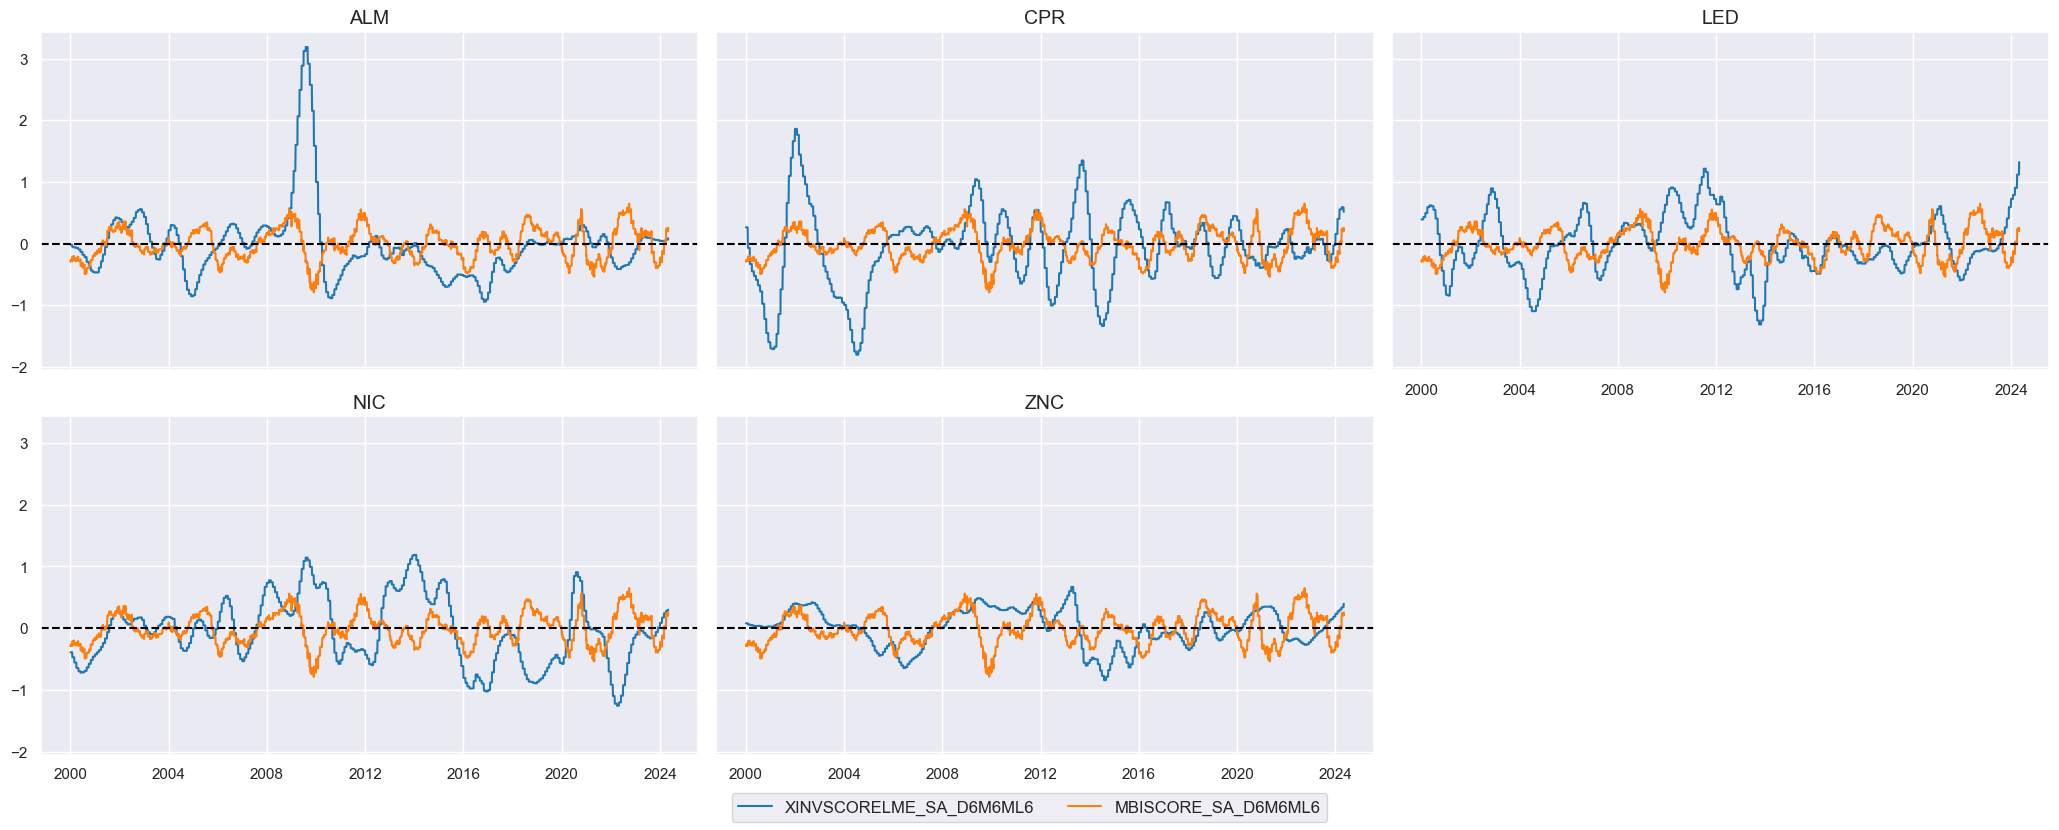

In [21]:
xcatx = ["XINVSCORELME_SA_D6M6ML6", "MBISCORE_SA_D6M6ML6"]

msp.view_timelines(
    dfx,
    cids=cids_lme,
    xcats=xcatx,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)

The process of standardizing related to excess commodity inventories, manufacturing inventory assessment scores and their changes is achieved through the use of the [`make_zn_scores()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#normalize-panels-with-make-zn-scores) function from the `macrosynergy` package. Normalization is a key step in macroeconomic analysis, especially when dealing with data across different categories that vary in units and time series characteristics. In this process, the indicators are centered around a neutral value (zero) using historical data. This normalization is recalculated monthly. To mitigate the impact of statistical outliers, a cutoff of 3 standard deviations is employed. Post-normalization, the indicators (z-scores) are labeled with the suffix `_ZN`, indicating their adjusted status.

In [22]:
itypes = ["MBISCORE_SA", "XINVSCORELME_SA"]
itrans = ["3MMA", "D3M3ML3", "D6M6ML6", "3MMA_D1M1ML12"]
xcatx = [f"{itype}_{itran}" for itype in itypes for itran in itrans]
cidx = cids_lmx

for xc in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        min_obs=3 * 261,
        neutral="zero",
        thresh=3,
        est_freq="m",
        postfix = "_ZN"
    )
    dfx = msm.update_df(dfx, dfa)


The resulting z-scores for the two key indicators are displayed below using standard [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package

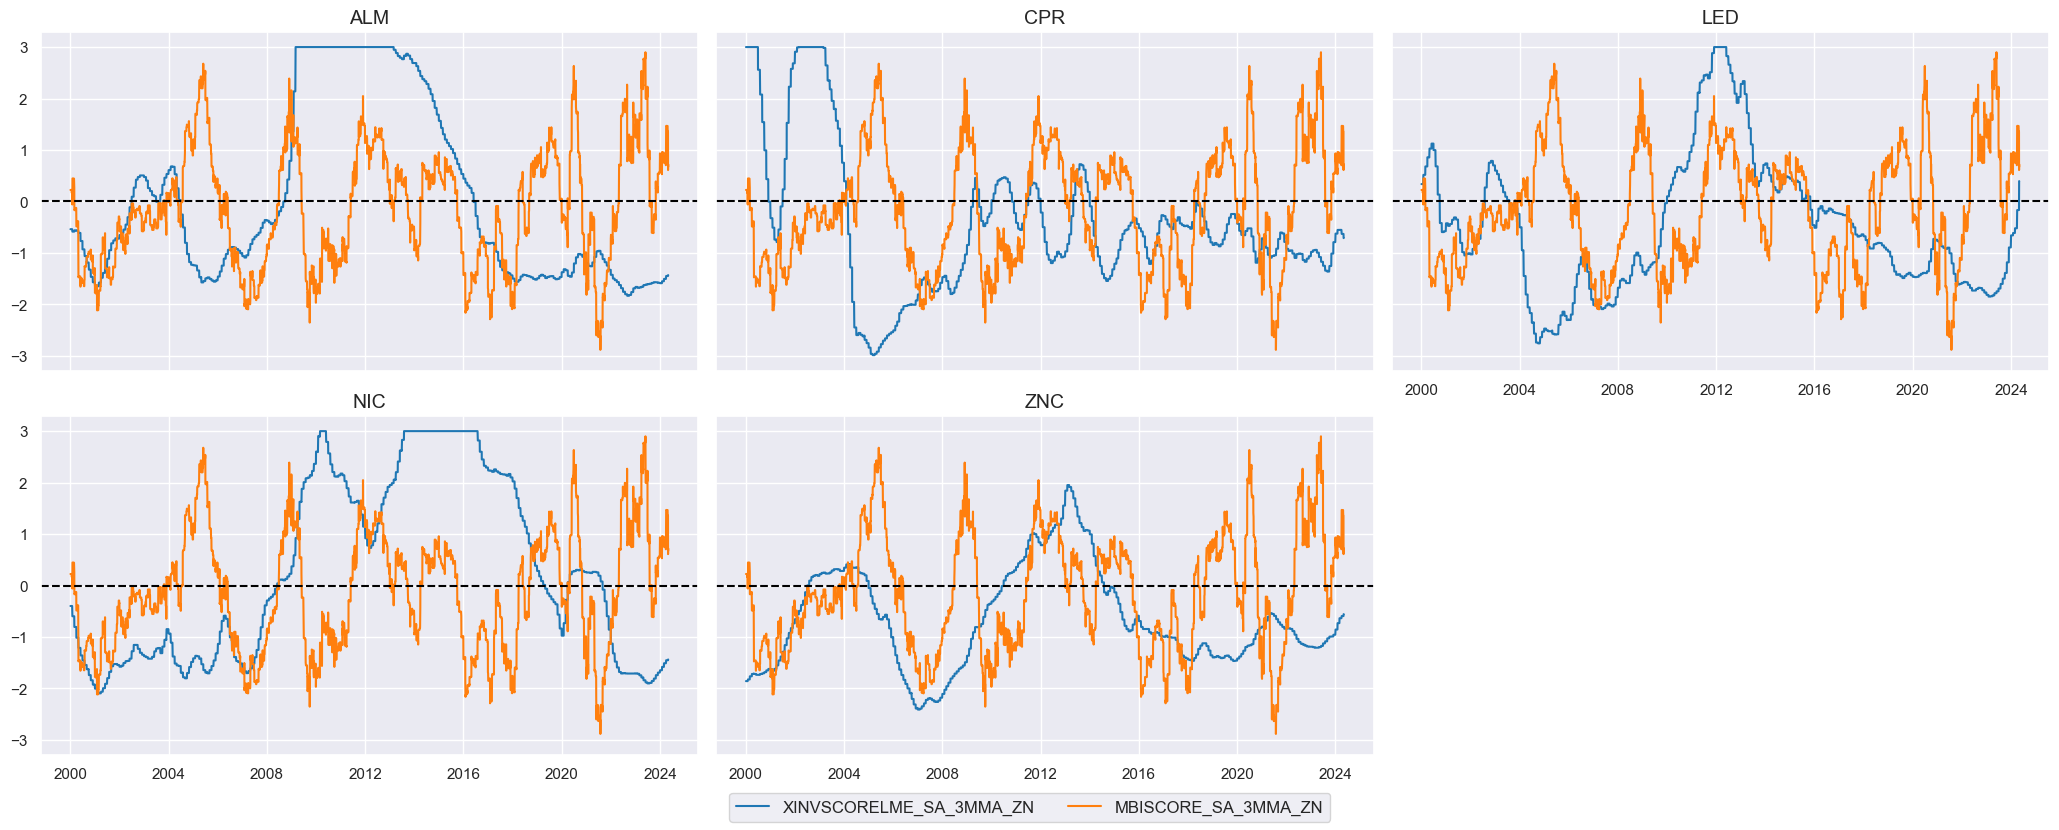

In [23]:
xcatx = ["XINVSCORELME_SA_3MMA_ZN", "MBISCORE_SA_3MMA_ZN"]

msp.view_timelines(
    dfx,
    cids=cids_lme,
    xcats=xcatx,
    title=None,
    title_fontsize=16,
    size=(12, 5),
)

Here we calculate normalized scores of commodity-specific excess inventories and their differences, i.e., a score for each of the transformations mentioned above. Then, we do the same for each derivative of the manufacturing inventory assessment score. Based on these, we calculate averages of the scores of commodity inventories and manufacturing inventory assessments, which produces composite inventory scores for each base metal. They are half metal-specific and half a reflection of the state of global manufacturing inventories. 

In [24]:
# Dictionary for inventory composites

keys = ["ISCORE_SA_" + itran + "_CZS" for itran in itrans]
values = [[f"MBISCORE_SA_{itran}_ZN", f"XINVSCORELME_SA_{itran}_ZN"] for itran in itrans]
dict_izn = dict(zip(keys, values))

# Composite for each inventory score

cidx = cids_lmx
dfa = pd.DataFrame(columns=dfx.columns)

for key, value in dict_izn.items():
    dfaa = msp.linear_composite(dfx, xcats=value, cids=cidx, new_xcat=key, complete_xcats=False)
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

The below panel illustrates this combination for the 3-month average levels of both types of scores.

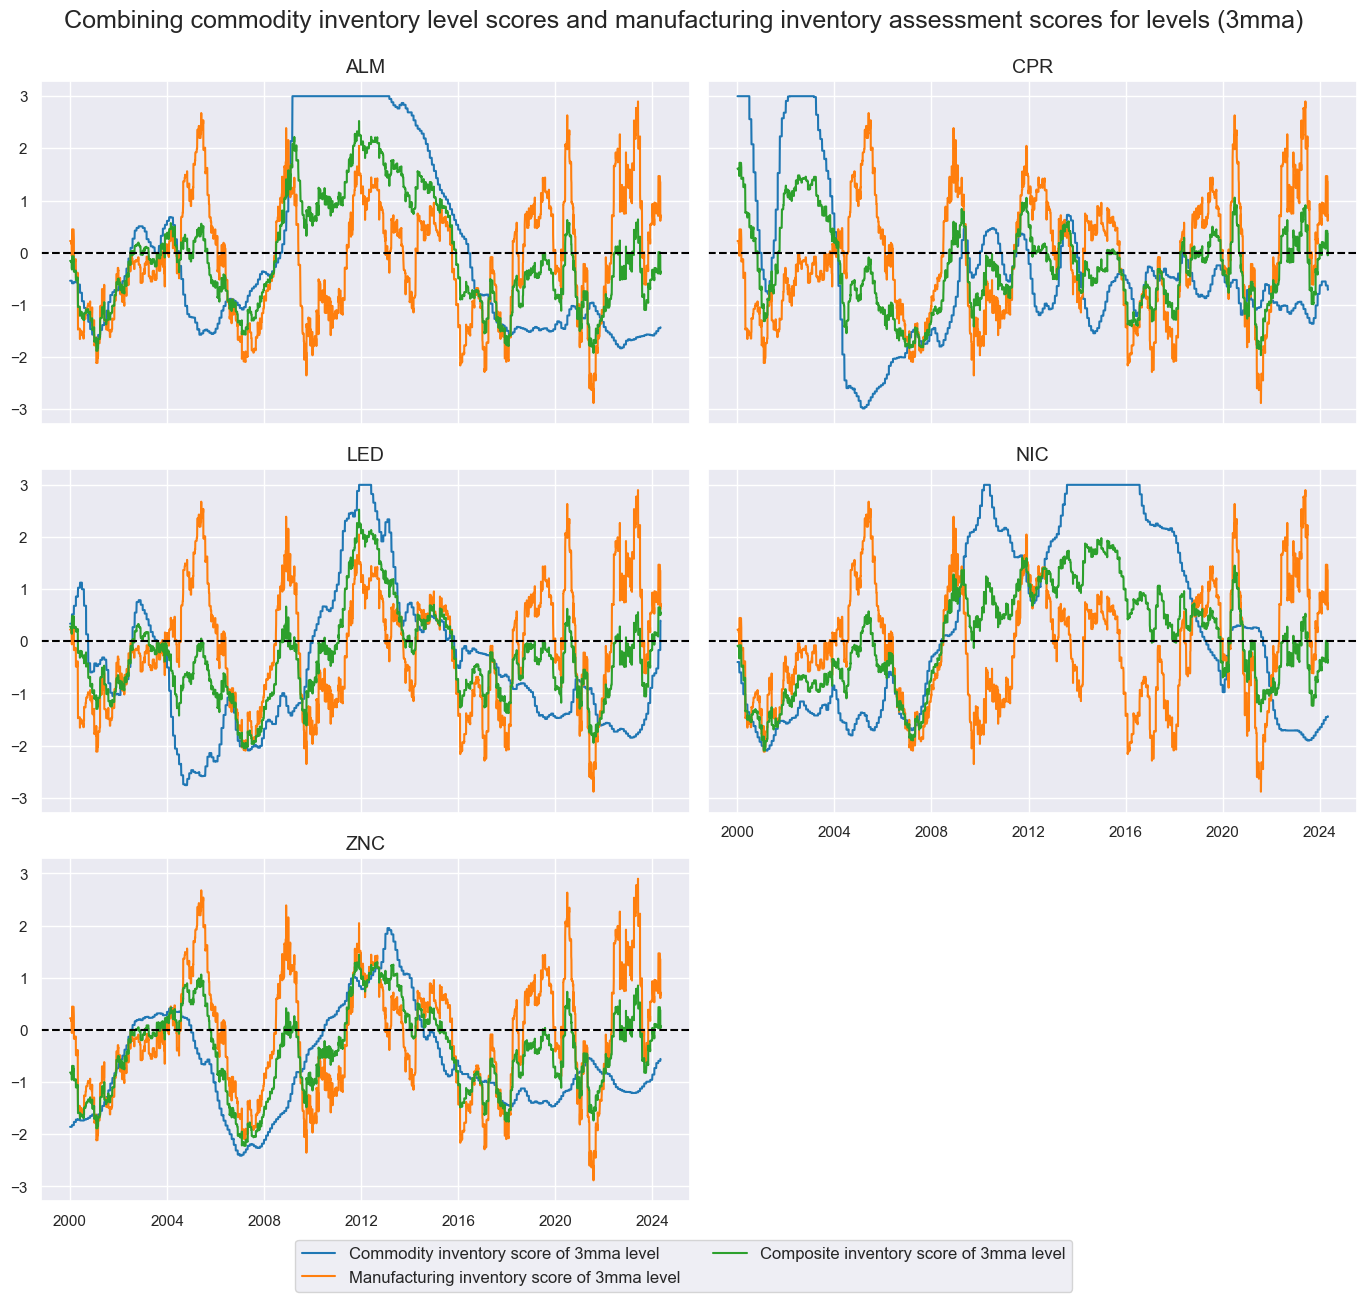

In [25]:
cidx = cids_lme
itran = "3MMA"

xcatx = [
    f"XINVSCORELME_SA_{itran}_ZN",
    f"MBISCORE_SA_{itran}_ZN",
    f"ISCORE_SA_{itran}_CZS",
]


msp.view_timelines(

    dfx,
    ncol=2,
    cids=cidx,

    xcats=xcatx,
    xcat_labels=[
        "Commodity inventory score of 3mma level",
        "Manufacturing inventory score of 3mma level",
        "Composite inventory score of 3mma level",
    ],

    title="Combining commodity inventory level scores and manufacturing inventory assessment scores for levels (3mma)",
    title_fontsize=18,
    size=(12, 5),

)

analogously to the manufacturing inventory assessment scores, we calculate a composite inventory score that averages over all transformations.

In [26]:
# Dictionary for cross-transformation composites

scores = ["XINVSCORELME_SA", "MBISCORE_SA", "ISCORE_SA"]
cidx = cids_lmx
dfa = pd.DataFrame(columns=dfx.columns)

for score in scores:
    if score is not "ISCORE_SA":
        xcatx = [f"{score}_{itran}_ZN" for itran in itrans]
    else:
        xcatx = [f"{score}_{itran}_CZS" for itran in itrans]
    dfaa = msp.linear_composite(
        dfx, xcats=xcatx, cids=cidx, new_xcat=score + "_CZS", complete_xcats=False
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

The resulting time series `ISCORE_SA_CZS` is displayed below for each contract:

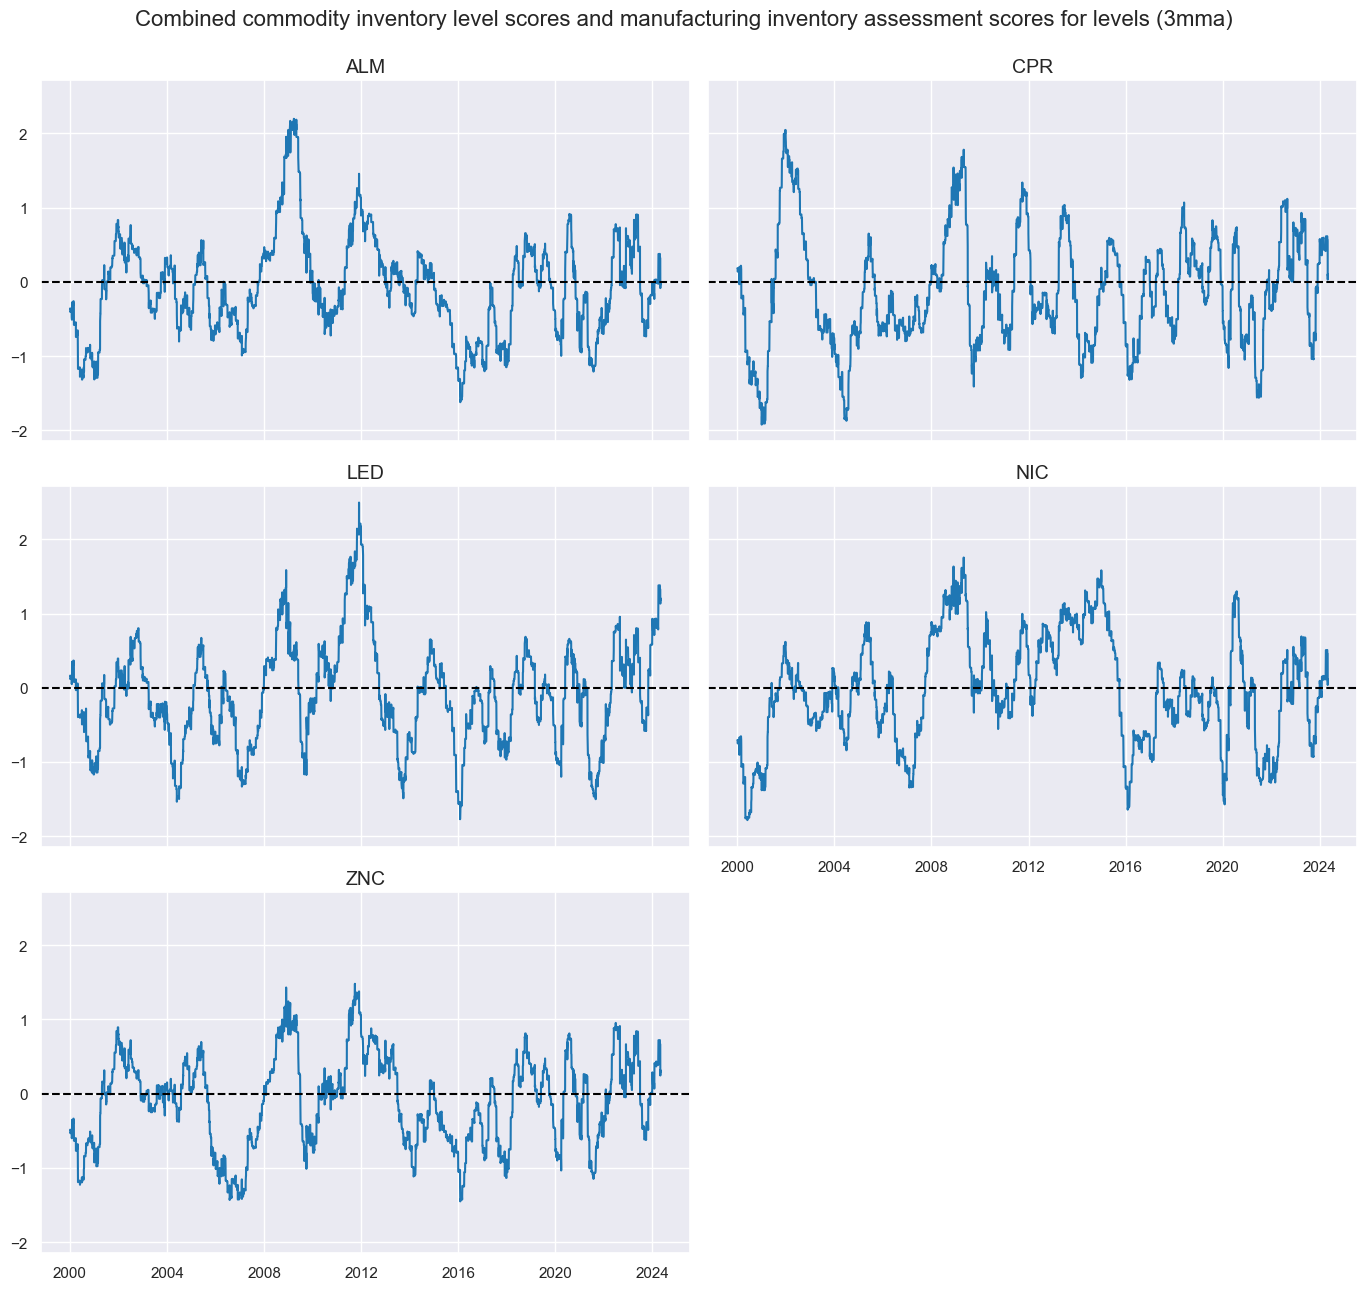

In [27]:
xcatx = ["ISCORE_SA_CZS"]

msp.view_timelines(
    dfx,
    cids=cids_lme,
    xcats=xcatx,
    ncol=2,
    title="Combined commodity inventory level scores and manufacturing inventory assessment scores for levels (3mma)",
    title_fontsize=16,
    size=(12, 5),
)

### Returns and hedging

In this section of the notebook, we analyze Commodity future returns as a percentage of notional, using  [`COXR_NSA`and `COXR_VT10`](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php), as our directional target. To effectively visualize them `EQXR_NSA` data across different contracts, we utilize two helpful functions from the Macrosynergy package: [`view_ranges()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-distributions-with-view-ranges) and [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines). The `view_ranges()` function is used for plotting the distributions of means and standard deviations, while `view_timelines()` is employed for illustrating the time series of these indicators, providing a comprehensive and clear visual representation of the data.

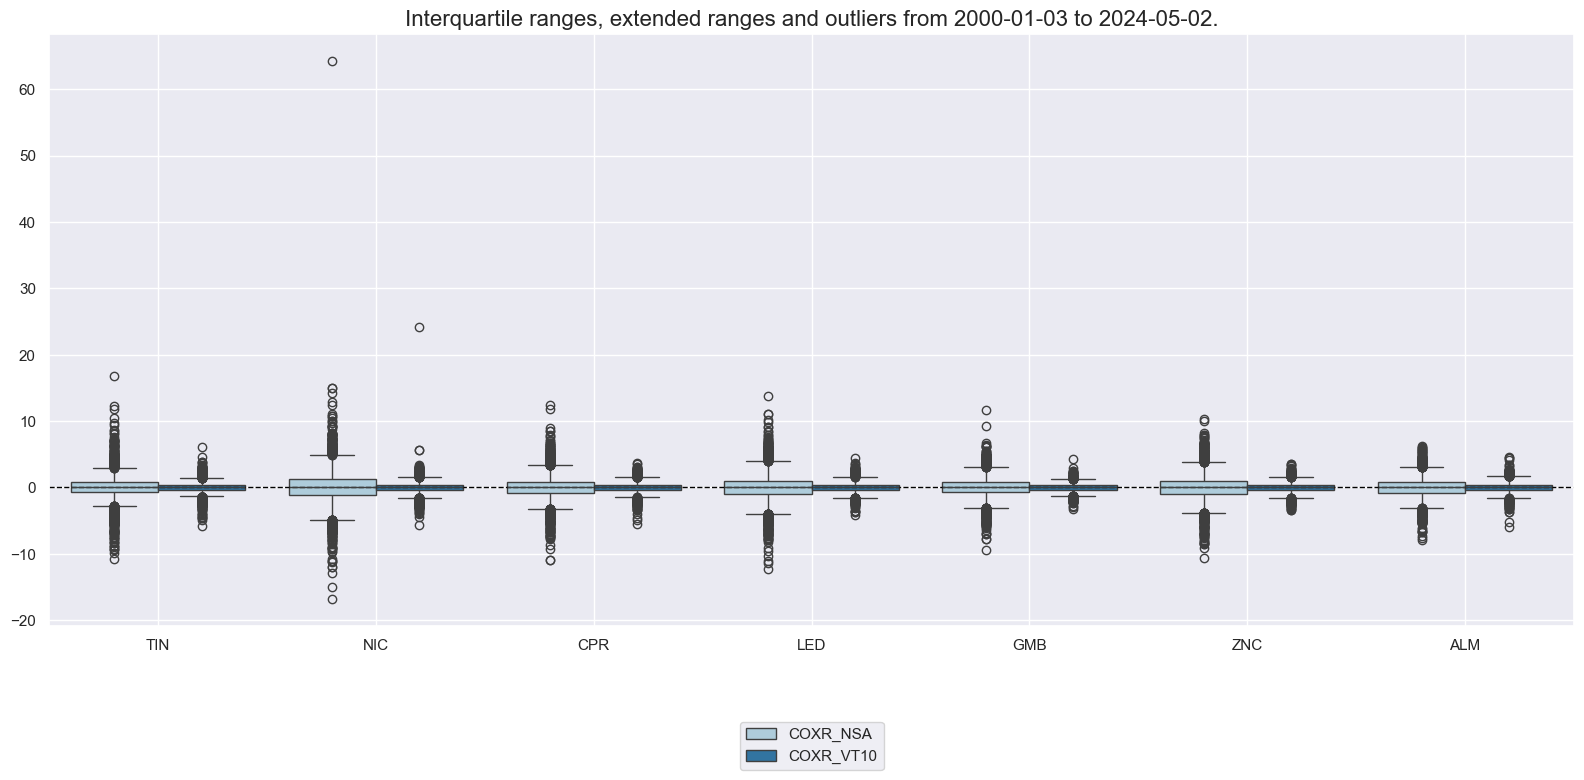

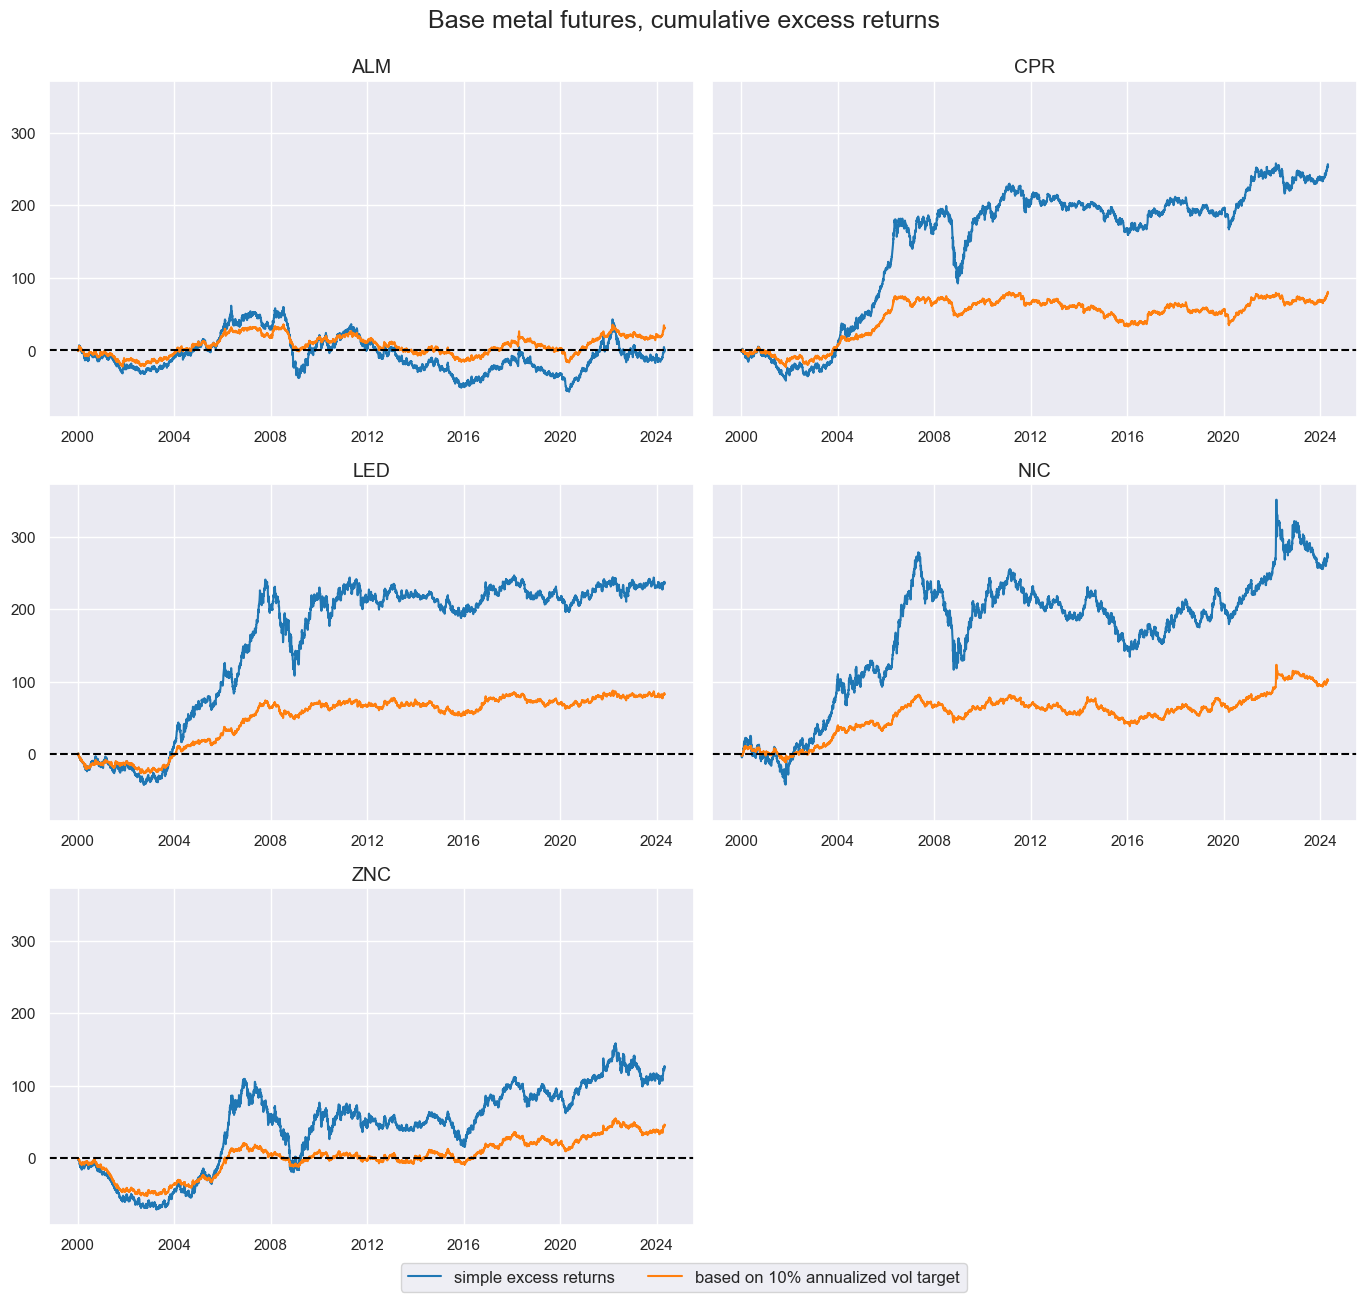

In [28]:
xcatx = ["COXR_NSA", "COXR_VT10"]
cidx = cids_lme

msp.view_ranges(
    dfx,
    xcats=xcatx,
    kind="box",
    sort_cids_by="mean",  # countries sorted by mean of the first category
    title=None,
    ylab=None,
    start="2000-01-01",
)

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    all_xticks=True,
    title="Base metal futures, cumulative excess returns",
    title_fontsize=18,
    xcat_labels=["simple excess returns", "based on 10% annualized vol target"],
)

The function `return_beta()` estimates betas (elasticities) of a return category to a benchmark. It returns either just the betas or hedged returns of the cross-sections. Hedged returns are returns on a composite position on the principal contract and the benchmark to offset the elasticity of the former with respect to the latter. If `oos` is set to True, the function calculates hedge ratios out of sample, i.e., for each period based on estimates up to the previous period. The related re-estimation frequency is set to monthly. The re-estimation is conducted at the end of the period and used as a hedge ratio for all days in the following period. 

The auxiliary function `.beta_display()` visualizes the estimated elasticities.

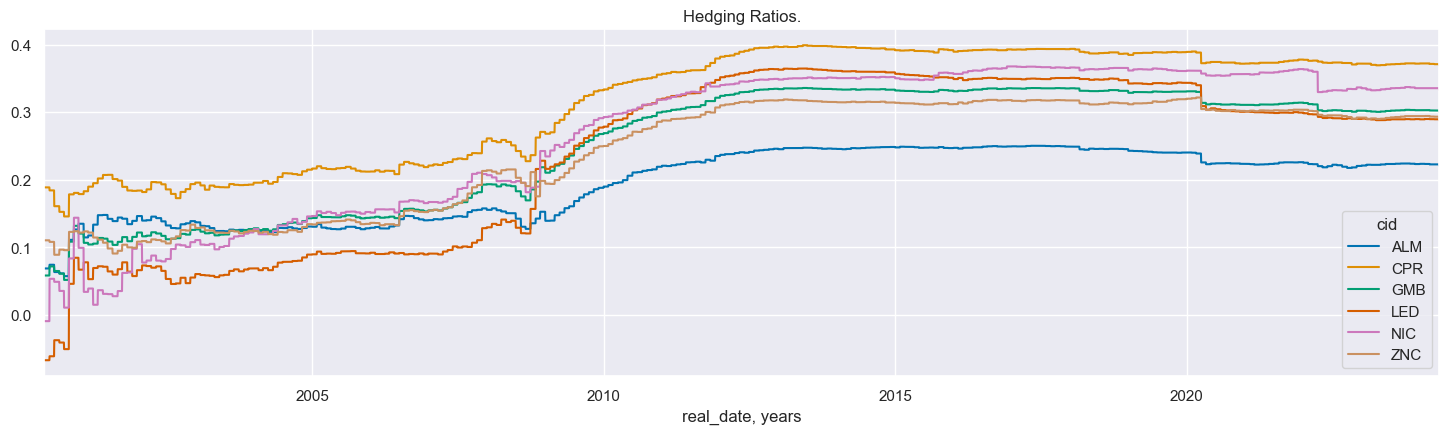

In [29]:
cidx = cids_lmx

dfh = msp.return_beta(
    dfx,
    xcat="COXR_NSA",
    cids=cidx,
    benchmark_return="USD_EQXR_NSA",
    oos=True,
    min_obs=90,
    max_obs=504,
    hedged_returns=True,
    start="2000-01-01",
    refreq="m",
    hr_name="HvSP500",
)

dfx = msm.update_df(df=dfx, df_add=dfh)

msp.beta_display(dfh, hr_name="HvSP500")

The hedged return, displayed alongside the original series, shows a very close alignment:

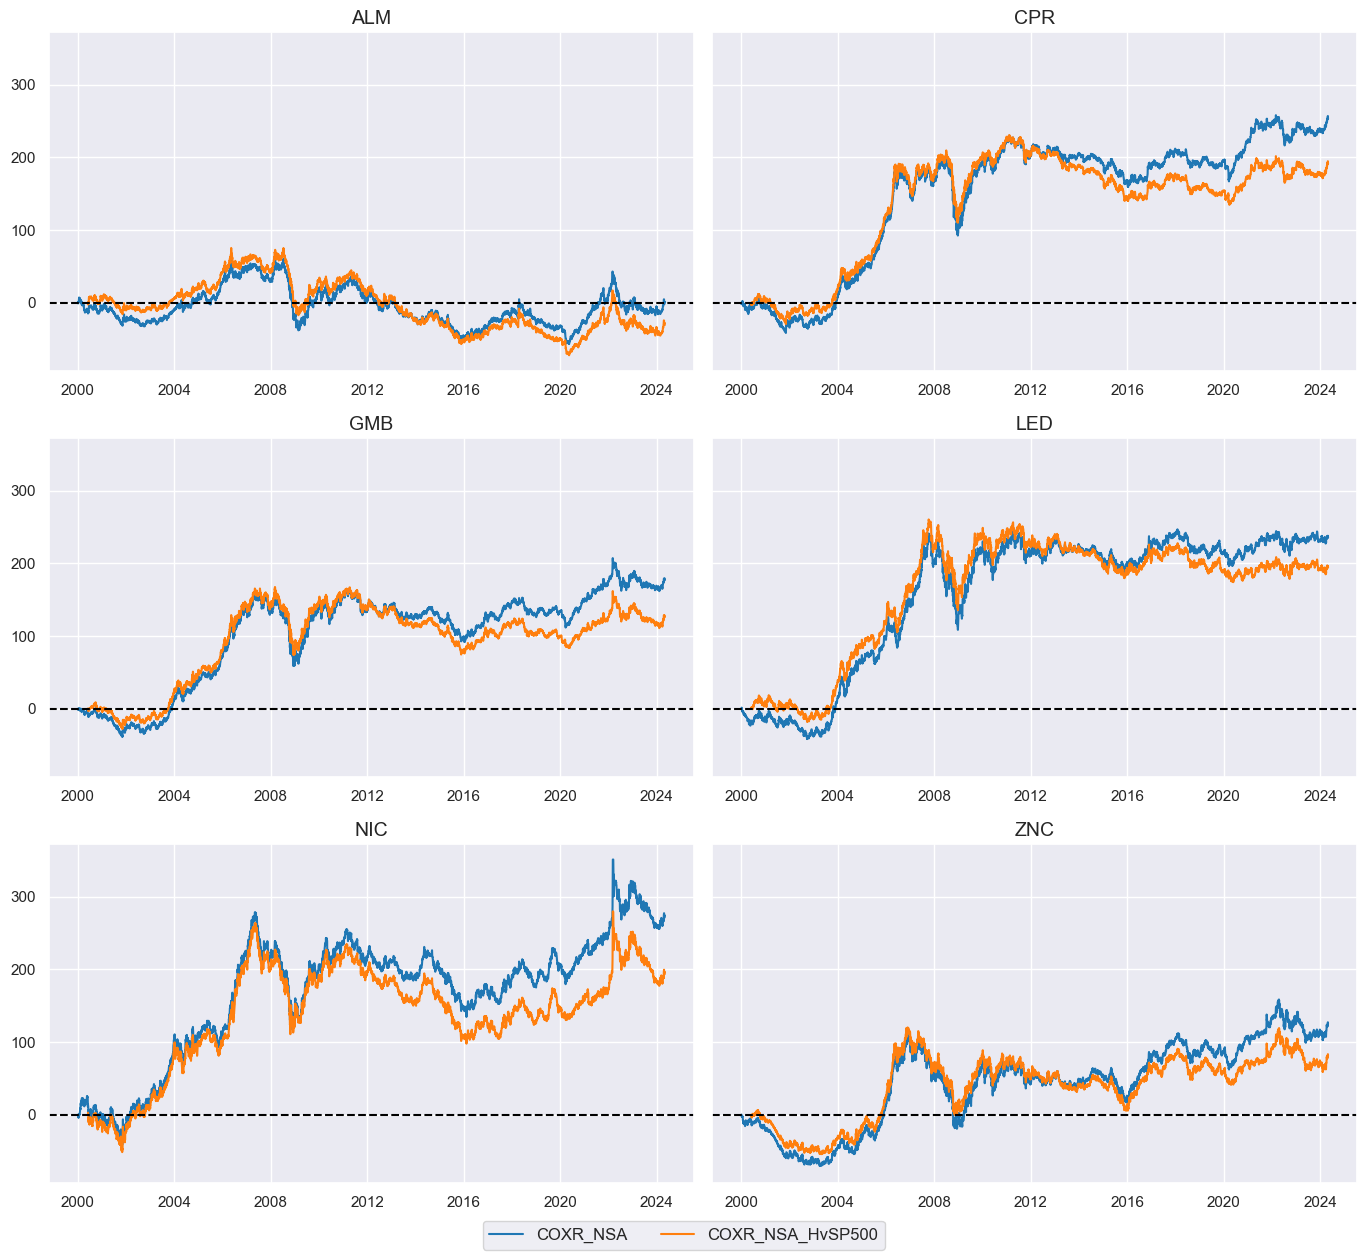

In [30]:
xcatx = ["COXR_NSA", "COXR_NSA_HvSP500"]
cidx = cids_lmx

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    all_xticks=True,
)

## Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for metal future returns using composite inventory and manufacturing inventory assessment scores indicators. The PnLs are calculated based on simple trading strategies that utilize the indicators as signals (no regression is involved). The strategies involve going long (buying) or short (selling) on returns based purely on the direction of the score signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between indicator changes and consequent financial returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of the confidence score-based strategies in predicting market movements. Standard accuracy metrics include accuracy rate, balanced accuracy, precision, etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws, etc.


The notebook examines two distinct types of strategies:

- _Directional basket strategy_: This strategy operates under the hypothesis that high or increasing finished goods inventories in the industrial sector negatively predict subsequent returns on base metals futures. The approach assumes a broad market impact and applies to aggregated metal contracts.
- _Directional contract strategy_: This strategy builds on the premise that commodity-specific excess inventory scores enhance the value derived from manufacturing inventory scores. It provides contract-specific signals that influence not only the direction and size of exposure to metals but also the allocation among individual contracts, tailoring the strategy to specific market dynamics.

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

### Directional basket strategy

#### Specs

In [31]:
itrans = ["3MMA", "D3M3ML3", "D6M6ML6", "3MMA_D1M1ML12"]
scores = [f"MBISCORE_SA_{itran}_ZN" for itran in itrans]

ms = 'MBISCORE_SA_CZS'
oths = scores

targ = "COXR_NSA"  # COXR_NSA_HvSP500 (almost same results)
cidx = ["GMB"]
start = "2000-01-01"

dict_dbs = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories, in particular, 
  - Composite manufacturing inventory assessment score `MBISCORE_SA_CZS`, derived earlier, and 
  - subsequent base metal returns [`COXR_NSA`] 
  
for an equally weighted base metals futures basket. 
  
The `.reg_scatter()` within this function facilitates the visualization of the relationship between these two categories. It provides a linear regression line accompanied by a 95% confidence interval, aiding in understanding the strength of the association and identifying any outliers. This method is particularly useful for quantifying the linear dependencies and evaluating the potential impact of inventory levels on metal returns. The argument `lag` sets the lag (delay of arrival) of the first (feature) category in base periods (monthly in our example). This means, that the feature is related to subsequent targets and - thus - allows analyzing its predictive power.

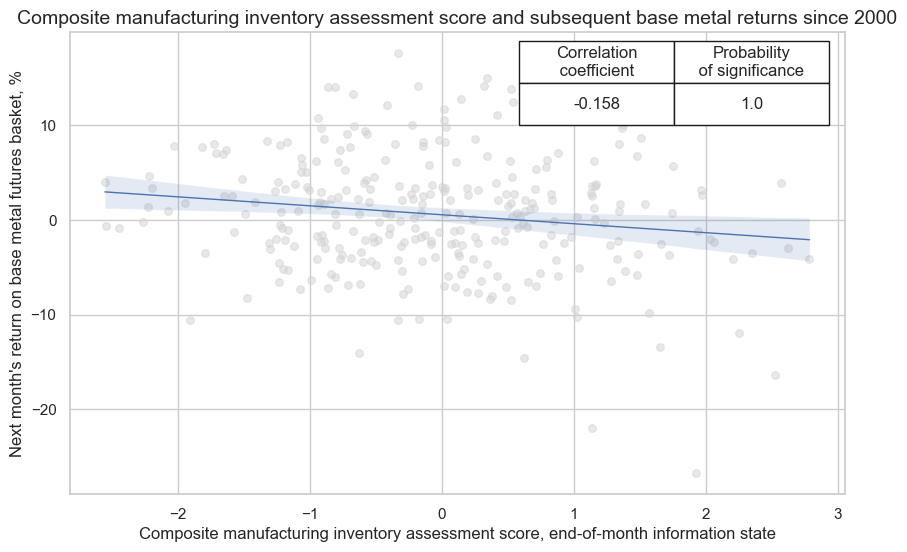

In [32]:
dix = dict_dbs

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)
crx.reg_scatter(
    labels=False,
    coef_box="upper right",
    title="Composite manufacturing inventory assessment score and subsequent base metal returns since 2000",
    xlab="Composite manufacturing inventory assessment score, end-of-month information state",
    ylab="Next month's return on base metal futures basket, %",
    prob_est="map",
    size=(10, 6),
)

#### Accuracy and correlation check

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [33]:
dix = dict_dbs

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

freqs = ["M", "Q"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] * (len(rivs) + 1),
    rets=targ,
    freqs=freqs,
    start=start,
)

dix["srr"] = srr

`multiple_relations_table()` method compares multiple signal-return relations in one table. It compares the performance of different signals against the same return series (more than one possible financial return) and multiple possible frequencies (monthly and quarterly as defined in `freqs` list). The method returns a table with standard columns and the rows display different signals from the list of signals specified upon SignalReturnsRelations () sigs. The row names indicate the frequency (‘D,’ ‘W,’ ‘M,’ ‘Q,’ ‘A’) followed by the signal’s and return’s names.

In [34]:
dix = dict_dbs
srrx = dix["srr"]
selcols = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",
    "pos_retr",
    "pearson",
    "pearson_pval",
    "kendall",
    "kendall_pval",
]
tbx = srrx.multiple_relations_table(freqs=freqs)[selcols].reset_index(level=['Return', 'Aggregation'], drop=True)



In [35]:
display(tbx.sort_index().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  \
Signal                           Frequency                                     
MBISCORE_SA_3MMA_D1M1ML12_ZN_NEG M             0.572         0.569     0.558   
                                 Q             0.598         0.584     0.598   
MBISCORE_SA_3MMA_ZN_NEG          M             0.503         0.498     0.572   
                                 Q             0.608         0.598     0.567   
MBISCORE_SA_CZS_NEG              M             0.524         0.522     0.524   
                                 Q             0.567         0.559     0.546   
MBISCORE_SA_D3M3ML3_ZN_NEG       M             0.521         0.521     0.493   
                                 Q             0.546         0.549     0.485   
MBISCORE_SA_D6M6ML6_ZN_NEG       M             0.531         0.529     0.524   
                                 Q             0.588         0.583     0.526   

                                            pos_retr  pearson  pearson_pval  \
Signal                           Frequency                                    
MBISCORE_SA_3MMA_D1M1ML12_ZN_NEG M             0.534    0.135         0.021   
                                 Q             0.588    0.145         0.156   
MBISCORE_SA_3MMA_ZN_NEG          M             0.534    0.089         0.128   
                                 Q             0.588    0.090         0.378   
MBISCORE_SA_CZS_NEG              M             0.534    0.158         0.007   
                                 Q             0.588    0.205         0.044   
MBISCORE_SA_D3M3ML3_ZN_NEG       M             0.534    0.142         0.015   
                                 Q             0.588    0.223         0.028   
MBISCORE_SA_D6M6ML6_ZN_NEG       M             0.534    0.144         0.014   
                                 Q             0.588    0.208         0.041   

                                            kendall  kendall_pval  
Signal                           Frequency                         
MBISCORE_SA_3MMA_D1M1ML12_ZN_NEG M            0.079         0.045  
                                 Q            0.106         0.124  
MBISCORE_SA_3MMA_ZN_NEG          M            0.054         0.168  
                                 Q            0.070         0.307  
MBISCORE_SA_CZS_NEG              M            0.081         0.038  
                                 Q            0.126         0.067  
MBISCORE_SA_D3M3ML3_ZN_NEG       M            0.080         0.043  
                                 Q            0.134         0.052  
MBISCORE_SA_D6M6ML6_ZN_NEG       M            0.080         0.042  
                                 Q            0.133         0.054

#### PnLs

[`NaivePnl()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not consider transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations. 

Important options within NaivePnl() function include: 

- `zn_score_pan` option, which transforms raw signals into z-scores around zero value based on the whole panel. The neutral level & standard deviation will use the cross-section of panels. zn-score here means standardized score with zero being the neutral level and standardization through division by mean absolute value. 

- rebalancing frequency (`rebal_freq`) for positions according to signal is chosen monthly,

- rebalancing slippage (`rebal_slip`) in days is 1, which means that it takes one day to rebalance the position and that the new position produces PnL from the second day after the signal has been recorded,

- threshold value (`thresh`) beyond which scores are winsorized, i.e., contained at that threshold. This is often realistic, as risk management and the potential of signal value distortions typically preclude outsized and concentrated positions within a strategy. We apply a threshold of 3

- `sig_add` - In this example, we create two PnLs: one neutral and one long-biased. For long-biased strategy we add one standard deviation to the normalized signals of the naïve PnL generator. This allows to give PnLs a long bias relative to the signal score. 

The method also allows ex-post scaling of PnL to an annualized volatility by assigning an annualized standard deviation of the aggregate PnL to the `vol_scale` argument. This is for comparative visualization only and very different from apriori volatility targeting.

We also generate a long-only Profit and Loss (PnL) statement and label it as "Long Only." 

In [36]:
dix = dict_dbs

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    bms=["GLB_DRBXR_NSA", "GEQ_DRBXR_NSA"],
)

sig_adds = [0, 1]

for sa in sig_adds:
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_add=sa,
            sig_op="zn_score_pan",
            thresh=3,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_PZN"+ str(sa),
        )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the `NaivePnl()` class plots a line chart of cumulative PnL based on the composite manufacturing inventory score (long bias, market neutral, and long only):

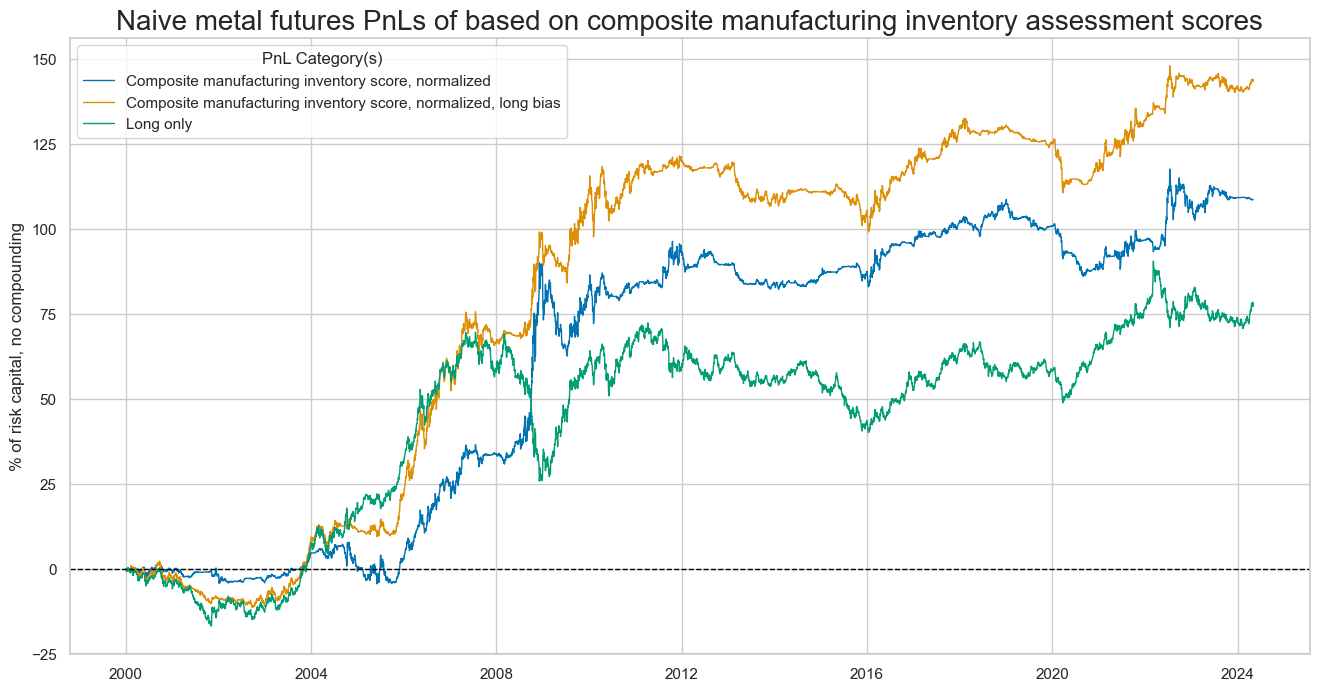

In [37]:
dix = dict_dbs

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]]
naive_pnl = dix["pnls"]

pnls = [s + "_" + type for s in sigx for type in ["PZN0", "PZN1"]] + ["Long only"]

dict_labels = {"MBISCORE_SA_CZS_PZN0": "Composite manufacturing inventory score, normalized", 
               "MBISCORE_SA_CZS_PZN1": "Composite manufacturing inventory score, normalized, long bias", 
               "Long only": "Long only"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive metal futures PnLs of based on composite manufacturing inventory assessment scores",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

We employ [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the `NaivePnl()` class plots to compare cumulative PnLs based on Manufacturing inventory scores, market neutral. i.e. no long bias, as well as on its differences:

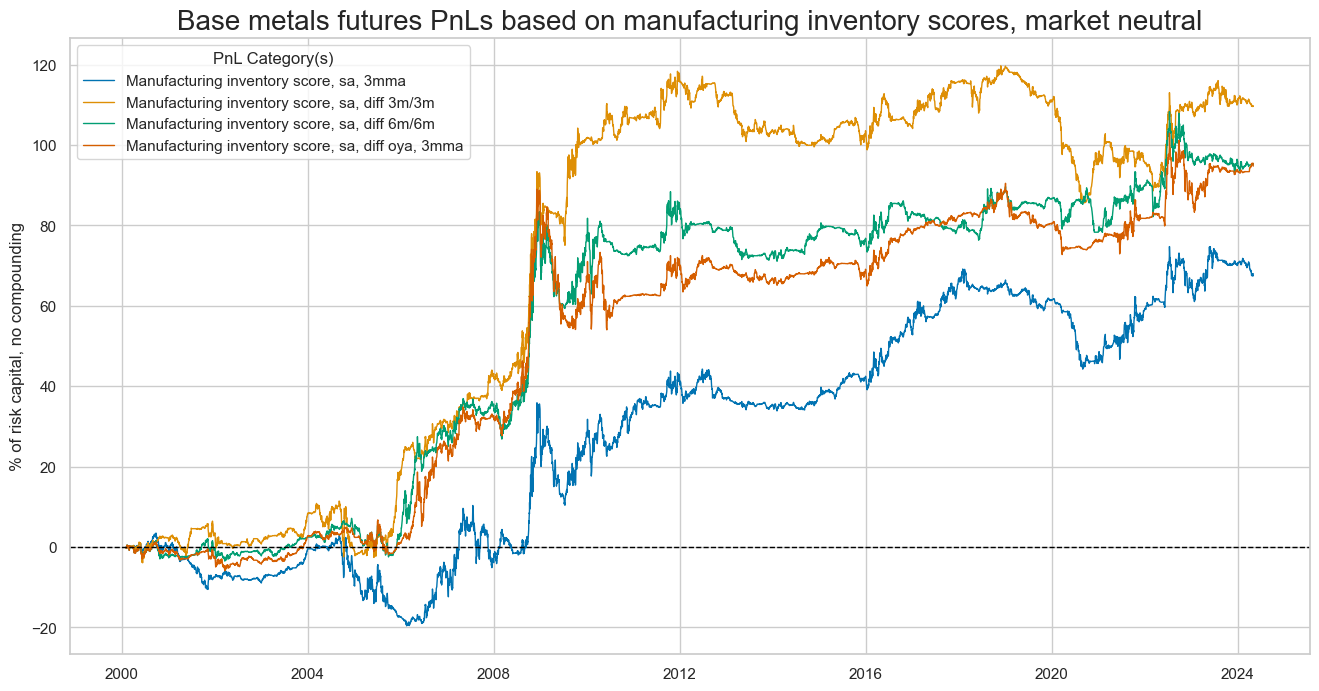

In [38]:
dix = dict_dbs

start = dix["start"]
cidx = dix["cidx"]
sigx = dix["rivs"]
naive_pnl = dix["pnls"]
type = "PZN0"
pnls = [s + "_" + type for s in sigx]

dict_labels = {
    f"MBISCORE_SA_3MMA_ZN_{type}": "Manufacturing inventory score, sa, 3mma",
    f"MBISCORE_SA_D3M3ML3_ZN_{type}": "Manufacturing inventory score, sa, diff 3m/3m",
    f"MBISCORE_SA_D6M6ML6_ZN_{type}": "Manufacturing inventory score, sa, diff 6m/6m",
    f"MBISCORE_SA_3MMA_D1M1ML12_ZN_{type}": "Manufacturing inventory score, sa, diff oya, 3mma",
}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Base metals futures PnLs based on manufacturing inventory scores, market neutral",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The [`evaluate_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) method displays standard performance metrics of market neutral naive PnLs for the directional basket strategy. 

In [39]:
dix = dict_dbs

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + type for s in sigx for type in ["_PZN0"]] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)


In [40]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                  
Long only                                3.172034              10.0   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN0        3.908374              10.0   
MBISCORE_SA_3MMA_ZN_PZN0                 2.805485              10.0   
MBISCORE_SA_CZS_PZN0                     4.478651              10.0   
MBISCORE_SA_D3M3ML3_ZN_PZN0              4.525329              10.0   
MBISCORE_SA_D6M6ML6_ZN_PZN0              3.934624              10.0   

                                  Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                           
Long only                             0.317203      0.453594      -19.368699   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN0     0.390837      0.561425      -14.886436   
MBISCORE_SA_3MMA_ZN_PZN0              0.280548       0.40688      -13.066985   
MBISCORE_SA_CZS_PZN0                  0.447865      0.660832      -13.672976   
MBISCORE_SA_D3M3ML3_ZN_PZN0           0.452533      0.673096      -13.123991   
MBISCORE_SA_D6M6ML6_ZN_PZN0           0.393462      0.574414       -16.67494   

                                  Max 6-month draw GLB_DRBXR_NSA correl  \
xcat                                                                      
Long only                               -30.646771             0.377323   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN0       -32.154733            -0.034936   
MBISCORE_SA_3MMA_ZN_PZN0                -22.810415             0.019189   
MBISCORE_SA_CZS_PZN0                    -24.500606            -0.027525   
MBISCORE_SA_D3M3ML3_ZN_PZN0             -20.685053            -0.045749   
MBISCORE_SA_D6M6ML6_ZN_PZN0             -23.249454            -0.028029   

                                  GEQ_DRBXR_NSA correl Traded Months  
xcat                                                                  
Long only                                     0.340319           293  
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN0            -0.028081           293  
MBISCORE_SA_3MMA_ZN_PZN0                      0.025867           293  
MBISCORE_SA_CZS_PZN0                         -0.023028           293  
MBISCORE_SA_D3M3ML3_ZN_PZN0                  -0.043007           293  
MBISCORE_SA_D6M6ML6_ZN_PZN0                  -0.027257           293

The same analysis is conducted using the [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method from the `NaivePnl()` class to visualize cumulative Profit and Loss (PnL) outcomes with a focus on strategies based on Manufacturing inventory score and its differences, maintaining a long bias. 

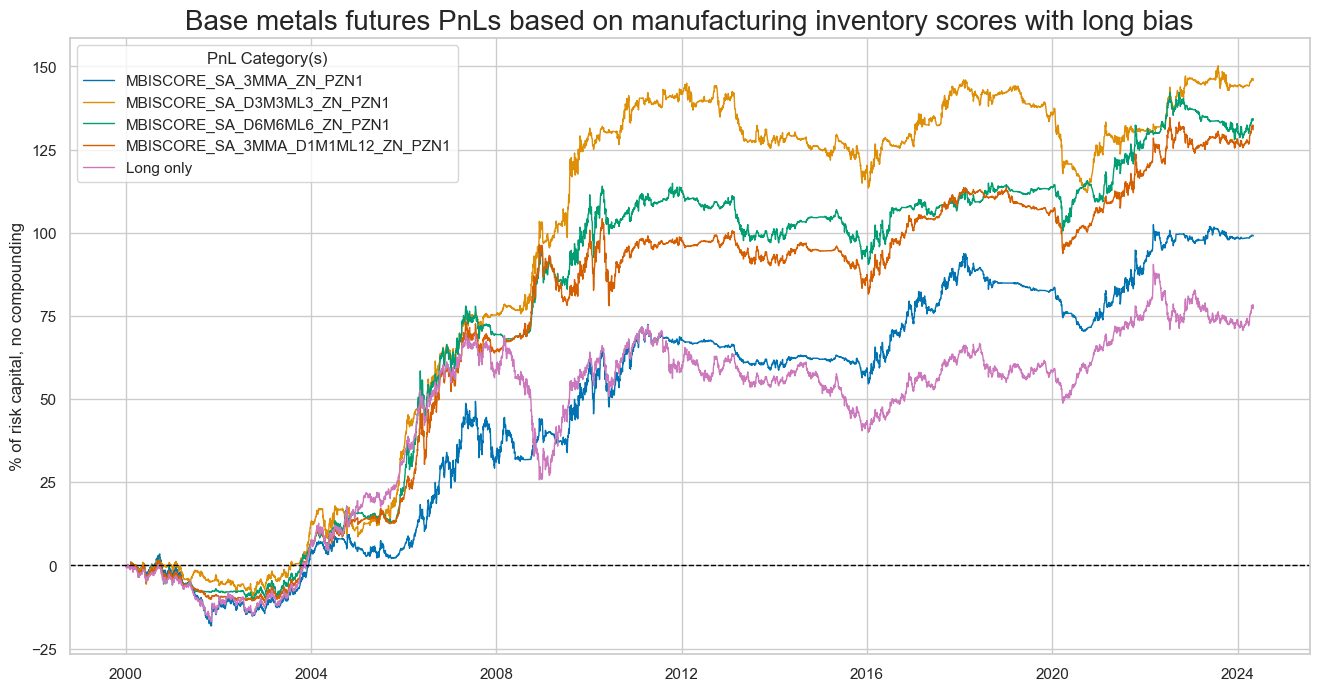

In [41]:
dix = dict_dbs

start = dix["start"]
cidx = dix["cidx"]
sigx = dix["rivs"]
naive_pnl = dix["pnls"]
type = "PZN1"
pnls = [s + "_" + type for s in sigx] + ["Long only"]

dict_labels = {
    f"MBISCORE_SA_3MMA_ZN_{type}": "Manufacturing inventory score, sa, 3mma",
    f"MBISCORE_SA_D3M3ML3_ZN_{type}": "Manufacturing inventory score, sa, diff 3m/3m",
    f"MBISCORE_SA_D6M6ML6_ZN_{type}": "Manufacturing inventory score, sa, diff 6m/6m",
    f"MBISCORE_SA_3MMA_D1M1ML12_ZN_{type}": "Manufacturing inventory score, sa, diff oya, 3mma",
    f"Long only": "Long only",
}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Base metals futures PnLs based on manufacturing inventory scores with long bias",
    # xcat_labels=dict_labels,
    figsize=(16, 8),
)

The [`evaluate_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) method displays standard performance metrics of long-biased naive PnLs using all created signals for the directional basket strategy.

In [42]:
dix = dict_dbs

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + type for s in sigx for type in ["_PZN1"]] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)


In [43]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                  
Long only                                3.172034              10.0   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN1        5.402092              10.0   
MBISCORE_SA_3MMA_ZN_PZN1                 4.086074              10.0   
MBISCORE_SA_CZS_PZN1                     5.914361              10.0   
MBISCORE_SA_D3M3ML3_ZN_PZN1              6.012577              10.0   
MBISCORE_SA_D6M6ML6_ZN_PZN1              5.520195              10.0   

                                  Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                           
Long only                             0.317203      0.453594      -19.368699   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN1     0.540209      0.777716      -17.640554   
MBISCORE_SA_3MMA_ZN_PZN1              0.408607      0.592763      -15.565183   
MBISCORE_SA_CZS_PZN1                  0.591436      0.866772      -15.915868   
MBISCORE_SA_D3M3ML3_ZN_PZN1           0.601258      0.887017      -12.160198   
MBISCORE_SA_D6M6ML6_ZN_PZN1           0.552019      0.806195      -16.615089   

                                  Max 6-month draw GLB_DRBXR_NSA correl  \
xcat                                                                      
Long only                               -30.646771             0.377323   
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN1       -18.438815             0.188417   
MBISCORE_SA_3MMA_ZN_PZN1                -14.632033              0.23672   
MBISCORE_SA_CZS_PZN1                    -15.059066              0.19147   
MBISCORE_SA_D3M3ML3_ZN_PZN1             -20.074591             0.183276   
MBISCORE_SA_D6M6ML6_ZN_PZN1             -13.376498             0.197245   

                                  GEQ_DRBXR_NSA correl Traded Months  
xcat                                                                  
Long only                                     0.340319           293  
MBISCORE_SA_3MMA_D1M1ML12_ZN_PZN1             0.174209           293  
MBISCORE_SA_3MMA_ZN_PZN1                       0.22134           293  
MBISCORE_SA_CZS_PZN1                          0.175714           293  
MBISCORE_SA_D3M3ML3_ZN_PZN1                   0.164931           293  
MBISCORE_SA_D6M6ML6_ZN_PZN1                   0.176796           293

### Directional contract strategy

#### Specs


The hypothesis tested in this part of the notebook explores the idea that commodity-specific excess inventory scores can significantly augment the value derived from manufacturing inventory scores. It suggests that these specialized scores provide tailored, contract-specific signals which influence not only the strategic direction and magnitude of exposure to metals but also refine the decision-making process regarding the allocation to specific contracts. This approach allows for more precise and effective management of investments in the metals sector.

In [44]:
itrans = ["3MMA", "D3M3ML3", "D6M6ML6", "3MMA_D1M1ML12"]
scores1 = [f"XINVSCORELME_SA_{itran}_ZN" for itran in itrans]
scores2 = [f"ISCORE_SA_{itran}_CZS" for itran in itrans]

ms = "ISCORE_SA_CZS"
oths = ["XINVSCORELME_SA_CZS"] + scores1 + scores2 

targ = "COXR_VT10"
cidx = cids_lme
start = "2000-01-01"

dict_dcs = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "srr": None,
    "pnls": None,
}

Instances of the class [`CategoryRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) of the `macrosynnergy.panel` package collect panels of features and targets in the appropriate form for analysis, including options for frequency conversion, lagging, and outlier trimming.  The `reg_scatter` method of the class displays a correlation scatter of the pooled data or a section thereof. Panel analysis shows that in line with the basic hypothesis there has been a negative relation between composite inventory scores and subsequent returns. The significance is very high, using the [Macrosynergy panel test](https://research.macrosynergy.com/testing-macro-trading-factors/).

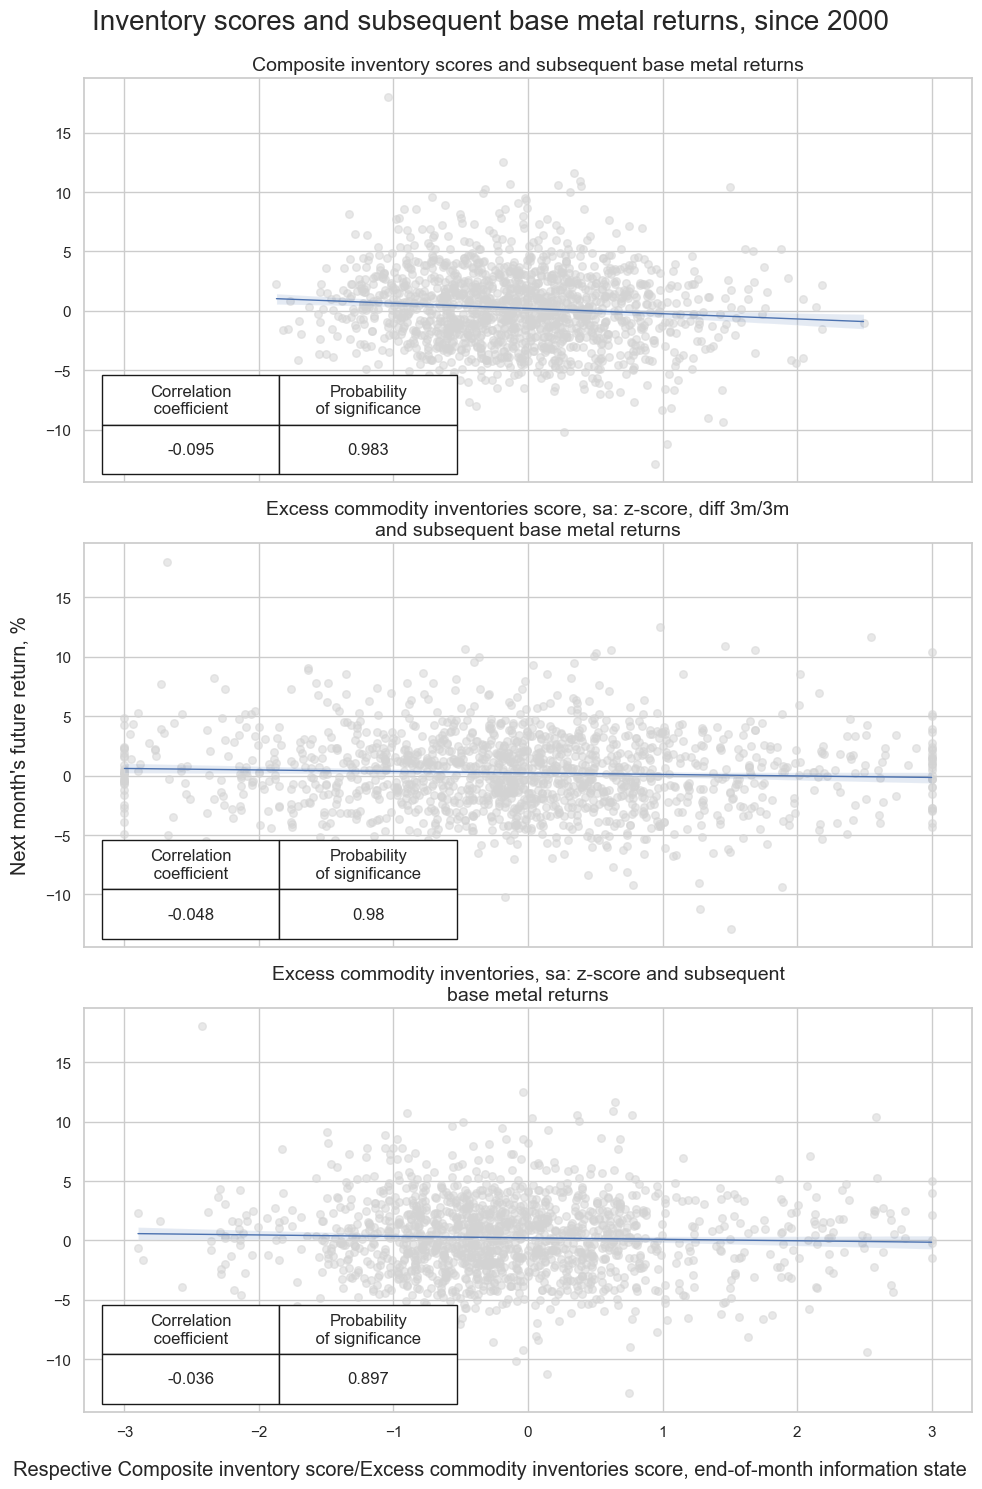

In [62]:
dix = dict_dcs

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)

crxx = msp.CategoryRelations(
    dfx,
    xcats=["XINVSCORELME_SA_D3M3ML3_ZN", targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)

crxxx = msp.CategoryRelations(
    dfx,
    xcats=["XINVSCORELME_SA_CZS", targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)

msv.multiple_reg_scatter(
        [crx, crxx, crxxx],
        title="Inventory scores and subsequent base metal returns, since 2000",
        xlab="Respective Composite inventory score/Excess commodity inventories score, end-of-month information state",
        ylab="Next month's future return, %",
        ncol=1,
        nrow=3,
        figsize=(10, 15),
        prob_est="map",
        coef_box="lower left", 
        subplot_titles=["Composite inventory scores and subsequent base metal returns", 
                        "Excess commodity inventories score, sa: z-score, diff 3m/3m and subsequent base metal returns", 
                        "Excess commodity inventories, sa: z-score and subsequent base metal returns"],
     )


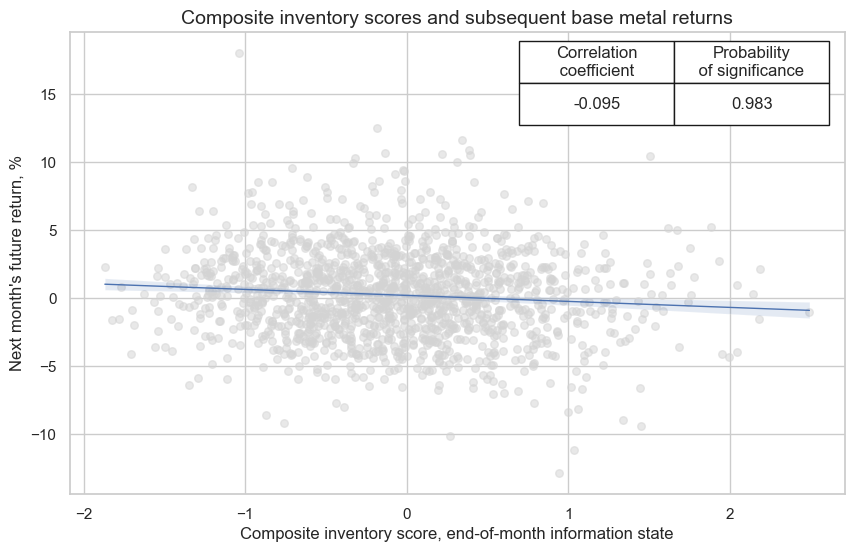

In [66]:
dix = dict_dcs

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)
crx.reg_scatter(
    labels=False,
    coef_box="upper right",
    title="Composite inventory scores and subsequent base metal returns",
    xlab="Composite inventory score, end-of-month information state",
    ylab="Next month's future return, %",
    prob_est="map",
    size=(10, 6),
)

#### Accuracy and correlation checks

As before, [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [46]:
dix = dict_dcs

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

freqs = ["M"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] * (len(rivs) + 1),
    rets=targ,
    freqs=freqs,
    start=start,
)

dix["srr"] = srr

[`multiple_relations_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) compares multiple signal-return relations in one table. It is useful to compare the performance of different signals against the same return series (more than one possible financial return) and multiple possible frequencies. 

In [47]:
dix = dict_dcs
srrx = dix["srr"]
selcols = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",
    "pos_retr",
    "pearson",
    "pearson_pval",
    "kendall",
    "kendall_pval",
]
tbx = srrx.multiple_relations_table(freqs=freqs)[selcols].reset_index(level=['Return', 'Aggregation'], drop=True)


In [48]:
display(tbx.sort_index().astype("float").round(3))

accuracy  bal_accuracy  \
Signal                               Frequency                           
ISCORE_SA_3MMA_CZS_NEG               M             0.507         0.502   
ISCORE_SA_3MMA_D1M1ML12_CZS_NEG      M             0.523         0.521   
ISCORE_SA_CZS_NEG                    M             0.530         0.528   
ISCORE_SA_D3M3ML3_CZS_NEG            M             0.529         0.529   
ISCORE_SA_D6M6ML6_CZS_NEG            M             0.535         0.534   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_NEG M             0.486         0.485   
XINVSCORELME_SA_3MMA_ZN_NEG          M             0.496         0.488   
XINVSCORELME_SA_CZS_NEG              M             0.510         0.506   
XINVSCORELME_SA_D3M3ML3_ZN_NEG       M             0.513         0.512   
XINVSCORELME_SA_D6M6ML6_ZN_NEG       M             0.513         0.512   

                                                pos_sigr  pos_retr  pearson  \
Signal                               Frequency                                
ISCORE_SA_3MMA_CZS_NEG               M             0.610     0.522    0.053   
ISCORE_SA_3MMA_D1M1ML12_CZS_NEG      M             0.563     0.522    0.076   
ISCORE_SA_CZS_NEG                    M             0.560     0.522    0.095   
ISCORE_SA_D3M3ML3_CZS_NEG            M             0.503     0.522    0.089   
ISCORE_SA_D6M6ML6_CZS_NEG            M             0.526     0.521    0.075   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_NEG M             0.525     0.522    0.012   
XINVSCORELME_SA_3MMA_ZN_NEG          M             0.658     0.522    0.029   
XINVSCORELME_SA_CZS_NEG              M             0.605     0.522    0.036   
XINVSCORELME_SA_D3M3ML3_ZN_NEG       M             0.534     0.522    0.048   
XINVSCORELME_SA_D6M6ML6_ZN_NEG       M             0.534     0.522    0.017   

                                                pearson_pval  kendall  \
Signal                               Frequency                          
ISCORE_SA_3MMA_CZS_NEG               M                 0.042    0.025   
ISCORE_SA_3MMA_D1M1ML12_CZS_NEG      M                 0.004    0.039   
ISCORE_SA_CZS_NEG                    M                 0.000    0.056   
ISCORE_SA_D3M3ML3_CZS_NEG            M                 0.001    0.060   
ISCORE_SA_D6M6ML6_CZS_NEG            M                 0.004    0.046   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_NEG M                 0.642   -0.006   
XINVSCORELME_SA_3MMA_ZN_NEG          M                 0.260    0.007   
XINVSCORELME_SA_CZS_NEG              M                 0.168    0.018   
XINVSCORELME_SA_D3M3ML3_ZN_NEG       M                 0.066    0.032   
XINVSCORELME_SA_D6M6ML6_ZN_NEG       M                 0.509    0.005   

                                                kendall_pval  
Signal                               Frequency                
ISCORE_SA_3MMA_CZS_NEG               M                 0.145  
ISCORE_SA_3MMA_D1M1ML12_CZS_NEG      M                 0.025  
ISCORE_SA_CZS_NEG                    M                 0.001  
ISCORE_SA_D3M3ML3_CZS_NEG            M                 0.001  
ISCORE_SA_D6M6ML6_CZS_NEG            M                 0.008  
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_NEG M                 0.721  
XINVSCORELME_SA_3MMA_ZN_NEG          M                 0.671  
XINVSCORELME_SA_CZS_NEG              M                 0.291  
XINVSCORELME_SA_D3M3ML3_ZN_NEG       M                 0.069  
XINVSCORELME_SA_D6M6ML6_ZN_NEG       M                 0.779


To streamline the focus on a particular signal, the [`.single_relation_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) method is employed. This method arranges the data effectively, starting with the first column, which specifies the frequency of data aggregation ('D' for daily, 'W' for weekly, 'M' for monthly, 'Q' for quarterly, 'A' for annually). This is followed by the name of the signal, which includes the suffix _NEG if there is a negative relationship and the name of the corresponding return. The table subsequently details the breakdown of the main signal by individual contract, offering a clear and organized view that facilitates in-depth analysis of how each contract contributes to the main signal. The table below focuses on composite inventory scores `ISCORE_SA_CZS`.

In [49]:
dix = dict_dcs
srrx = dix["srr"]

tbx = srrx.single_relation_table(
    ret="COXR_VT10", xcat="ISCORE_SA_CZS", freq="M", table_type="cross_section"
)[selcols]


In [50]:
display(tbx.astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  \
M: ISCORE_SA_CZS_NEG/last => COXR_VT10     0.530         0.528     0.560   
Mean                                       0.530         0.528     0.560   
PosRatio                                   0.800         0.800     1.000   
ALM                                        0.524         0.528     0.572   
CPR                                        0.538         0.528     0.599   
LED                                        0.558         0.552     0.572   
NIC                                        0.490         0.489     0.521   
ZNC                                        0.541         0.541     0.538   

                                        pos_retr  pearson  pearson_pval  \
M: ISCORE_SA_CZS_NEG/last => COXR_VT10     0.522    0.095         0.000   
Mean                                       0.522    0.098         0.171   
PosRatio                                   0.800    1.000         1.000   
ALM                                        0.473    0.139         0.018   
CPR                                        0.555    0.040         0.496   
LED                                        0.548    0.142         0.015   
NIC                                        0.524    0.068         0.247   
ZNC                                        0.510    0.103         0.078   

                                        kendall  kendall_pval  
M: ISCORE_SA_CZS_NEG/last => COXR_VT10    0.056         0.001  
Mean                                      0.055         0.265  
PosRatio                                  1.000         0.800  
ALM                                       0.087         0.027  
CPR                                       0.016         0.681  
LED                                       0.084         0.032  
NIC                                       0.032         0.412  
ZNC                                       0.054         0.172

[`.single_relation_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) method is used here to analyze `XINVSCORELME_SA_CZS`, composite excess commodity inventories related to the London Metal Exchange

In [51]:
dix = dict_dcs
srrx = dix["srr"]

tbx = srrx.single_relation_table(
    ret="COXR_VT10", xcat="XINVSCORELME_SA_CZS", freq="M", table_type="cross_section"
)[selcols]


In [52]:
display(tbx.astype("float").round(3))

accuracy  bal_accuracy  \
M: XINVSCORELME_SA_CZS_NEG/last => COXR_VT10     0.510         0.506   
Mean                                             0.510         0.505   
PosRatio                                         0.400         0.400   
ALM                                              0.479         0.484   
CPR                                              0.548         0.536   
LED                                              0.565         0.556   
NIC                                              0.473         0.467   
ZNC                                              0.486         0.485   

                                              pos_sigr  pos_retr  pearson  \
M: XINVSCORELME_SA_CZS_NEG/last => COXR_VT10     0.605     0.522    0.036   
Mean                                             0.605     0.522    0.041   
PosRatio                                         1.000     0.800    0.800   
ALM                                              0.589     0.473    0.037   
CPR                                              0.630     0.555   -0.002   
LED                                              0.647     0.548    0.105   
NIC                                              0.592     0.524    0.018   
ZNC                                              0.565     0.510    0.051   

                                              pearson_pval  kendall  \
M: XINVSCORELME_SA_CZS_NEG/last => COXR_VT10         0.168    0.018   
Mean                                                 0.545    0.019   
PosRatio                                             0.400    0.800   
ALM                                                  0.533    0.048   
CPR                                                  0.967    0.002   
LED                                                  0.074    0.058   
NIC                                                  0.763   -0.024   
ZNC                                                  0.388    0.009   

                                              kendall_pval  
M: XINVSCORELME_SA_CZS_NEG/last => COXR_VT10         0.291  
Mean                                                 0.535  
PosRatio                                             0.400  
ALM                                                  0.222  
CPR                                                  0.961  
LED                                                  0.141  
NIC                                                  0.539  
ZNC                                                  0.813

#### PnLs

To assess the effectiveness of trading signals, we again implement a naive Profit and Loss (PnL) approach. Based on this, a long-short portfolio is constructed—going long when the signal is positive and short when negative, with monthly rebalancing to adjust to new data. We evaluate this naive PnL using metrics like accuracy, balanced accuracy, positive signal and return rates, and both Pearson and Kendall correlations.

Additionally, two PnL variants are considered: a neutral strategy that adheres strictly to the signal, and a long-biased strategy which adds one standard deviation to the normalized signals to favor long positions. This method allows us to test the signal's predictive power and profitability under different trading biases.

In [53]:
dix = dict_dcs

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    bms=["GLB_DRBXR_NSA", "GEQ_DRBXR_NSA"],
)

sig_adds = [0, 1]

for sa in sig_adds:
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_add=sa,
            sig_op="zn_score_pan",
            thresh=3,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_PZN"+ str(sa),
        )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

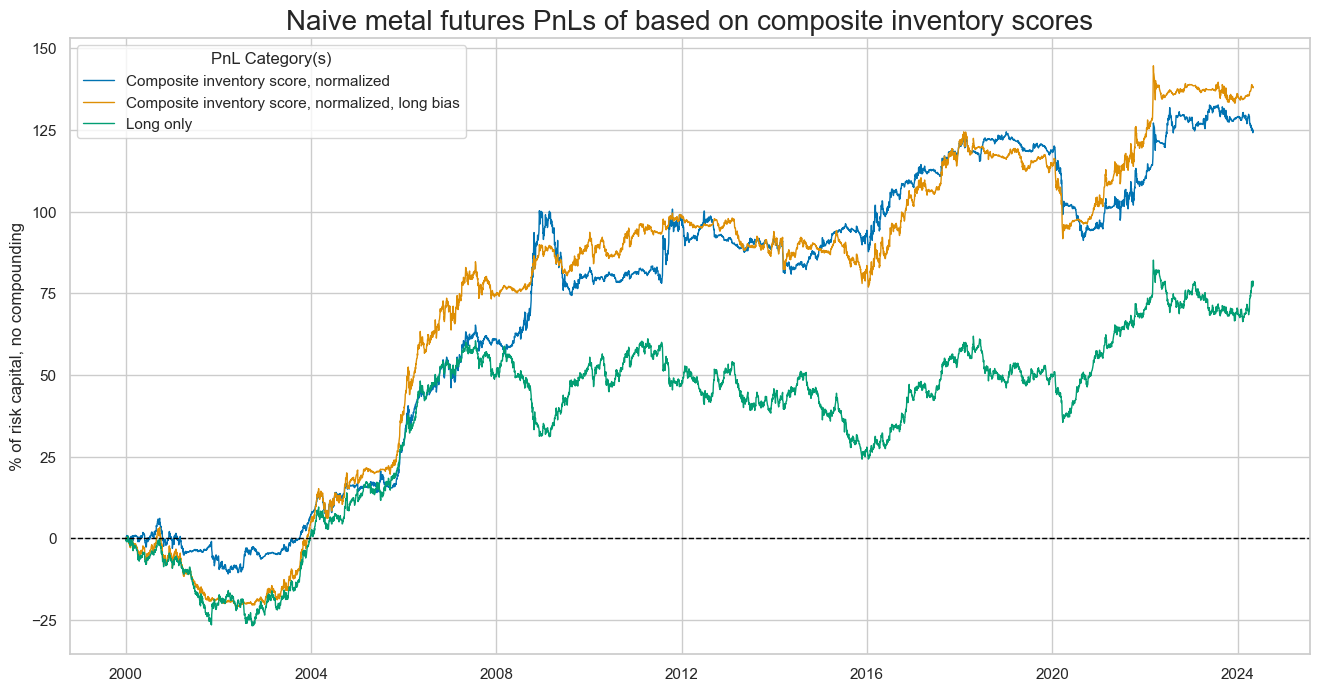

In [54]:
dix = dict_dcs

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]]
naive_pnl = dix["pnls"]
pnls = [s + type for s in sigx for type in ["_PZN0", "_PZN1"]] + ["Long only"]

dict_labels = {"ISCORE_SA_CZS_PZN0": "Composite inventory score, normalized", 
               "ISCORE_SA_CZS_PZN1": "Composite inventory score, normalized, long bias", 
               "Long only": "Long only"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive metal futures PnLs of based on composite inventory scores",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [55]:
sigx = [riv for riv in dix['rivs'] if riv.startswith('ISCORE')]
[s + "_PZN0" for s in sigx]

['ISCORE_SA_3MMA_CZS_PZN0',
 'ISCORE_SA_D3M3ML3_CZS_PZN0',
 'ISCORE_SA_D6M6ML6_CZS_PZN0',
 'ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0']

We employ [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the `NaivePnl()` class plots to compare cumulative PnLs based on Inventory score, market neutral. i.e. no long bias, as well as on its differences:

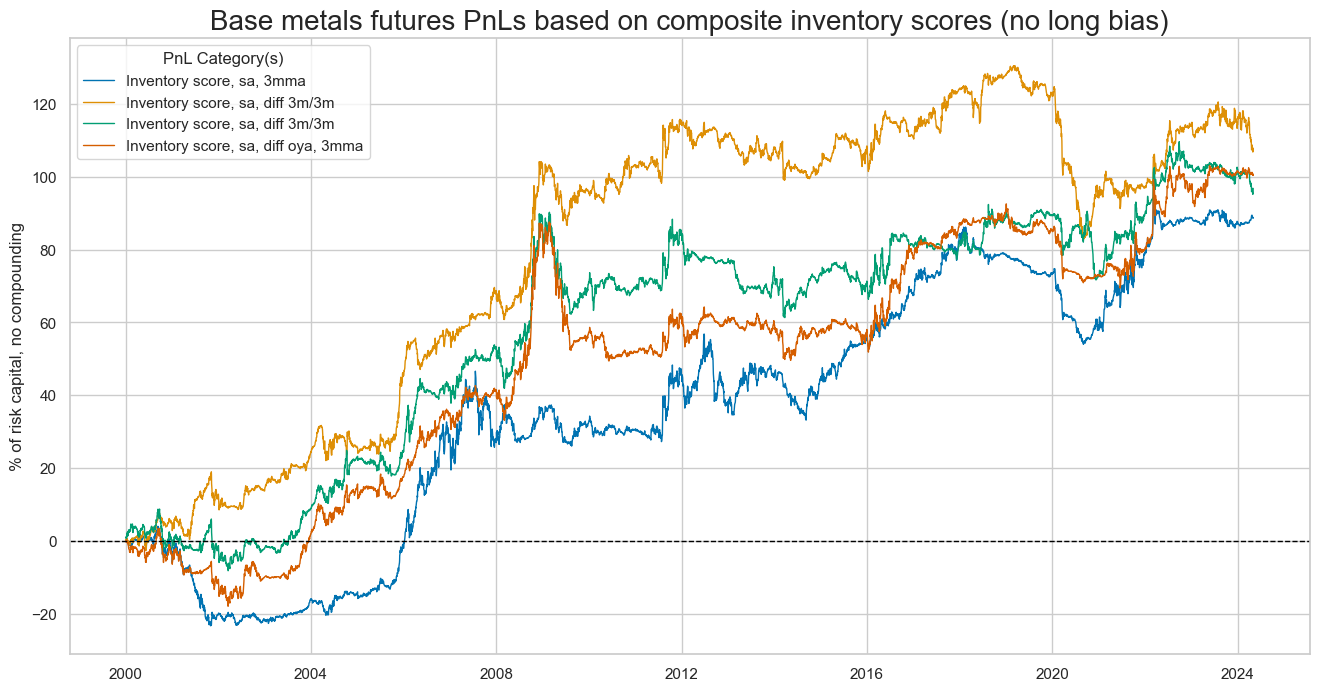

In [56]:
dix = dict_dcs

start = dix["start"]
cidx = dix["cidx"]
sigx = [riv for riv in dix['rivs'] if riv.startswith('ISCORE')]
naive_pnl = dix["pnls"]
type = "PZN0"
pnls = [s + "_" + type for s in sigx]

dict_labels = {
    f"ISCORE_SA_3MMA_CZS_{type}": "Inventory score, sa, 3mma",
    f"ISCORE_SA_D3M3ML3_CZS_{type}": "Inventory score, sa, diff 3m/3m",
    f"ISCORE_SA_D6M6ML6_CZS_{type}": "Inventory score, sa, diff 3m/3m",
    f"ISCORE_SA_3MMA_D1M1ML12_CZS_{type}": "Inventory score, sa, diff oya, 3mma",
}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Base metals futures PnLs based on composite inventory scores (no long bias)",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The [`evaluate_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) method displays standard performance metrics of market neutral naive PnLs for the directional contract strategy.

In [57]:
dix = dict_dcs

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + "_PZN0" for s in sigx] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)


In [58]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                      
ISCORE_SA_3MMA_CZS_PZN0                       3.64371              10.0   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0             4.127321              10.0   
ISCORE_SA_CZS_PZN0                           5.136485              10.0   
ISCORE_SA_D3M3ML3_CZS_PZN0                   4.434869              10.0   
ISCORE_SA_D6M6ML6_CZS_PZN0                   3.980731              10.0   
Long only                                    3.175902              10.0   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN0        1.112506              10.0   
XINVSCORELME_SA_3MMA_ZN_PZN0                 2.286824              10.0   
XINVSCORELME_SA_CZS_PZN0                     2.638175              10.0   
XINVSCORELME_SA_D3M3ML3_ZN_PZN0              3.185212              10.0   
XINVSCORELME_SA_D6M6ML6_ZN_PZN0              1.387788              10.0   

                                      Sharpe Ratio Sortino Ratio  \
xcat                                                               
ISCORE_SA_3MMA_CZS_PZN0                   0.364371      0.520187   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0          0.412732      0.602657   
ISCORE_SA_CZS_PZN0                        0.513649      0.752243   
ISCORE_SA_D3M3ML3_CZS_PZN0                0.443487      0.643148   
ISCORE_SA_D6M6ML6_CZS_PZN0                0.398073      0.574123   
Long only                                  0.31759      0.454225   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN0     0.111251       0.16341   
XINVSCORELME_SA_3MMA_ZN_PZN0              0.228682      0.327243   
XINVSCORELME_SA_CZS_PZN0                  0.263817      0.395398   
XINVSCORELME_SA_D3M3ML3_ZN_PZN0           0.318521      0.472628   
XINVSCORELME_SA_D6M6ML6_ZN_PZN0           0.138779      0.206453   

                                      Max 21-day draw Max 6-month draw  \
xcat                                                                     
ISCORE_SA_3MMA_CZS_PZN0                    -16.558888       -19.928157   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0           -12.912846       -34.442796   
ISCORE_SA_CZS_PZN0                         -14.200764       -25.746911   
ISCORE_SA_D3M3ML3_CZS_PZN0                 -15.317954       -32.971423   
ISCORE_SA_D6M6ML6_CZS_PZN0                 -12.722348       -27.654686   
Long only                                   -12.89172       -21.260647   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN0      -14.094985       -33.119007   
XINVSCORELME_SA_3MMA_ZN_PZN0               -12.700086       -15.997663   
XINVSCORELME_SA_CZS_PZN0                   -11.674073       -29.264338   
XINVSCORELME_SA_D3M3ML3_ZN_PZN0            -14.235394       -31.003139   
XINVSCORELME_SA_D6M6ML6_ZN_PZN0            -15.370661       -33.995502   

                                      GLB_DRBXR_NSA correl  \
xcat                                                         
ISCORE_SA_3MMA_CZS_PZN0                           0.020302   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0                 -0.030746   
ISCORE_SA_CZS_PZN0                               -0.019269   
ISCORE_SA_D3M3ML3_CZS_PZN0                       -0.033566   
ISCORE_SA_D6M6ML6_CZS_PZN0                       -0.021576   
Long only                                          0.37178   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN0            -0.055667   
XINVSCORELME_SA_3MMA_ZN_PZN0                     -0.005793   
XINVSCORELME_SA_CZS_PZN0                         -0.039784   
XINVSCORELME_SA_D3M3ML3_ZN_PZN0                  -0.038841   
XINVSCORELME_SA_D6M6ML6_ZN_PZN0                  -0.052313   

                                      GEQ_DRBXR_NSA correl Traded Months  
xcat                                                                      
ISCORE_SA_3MMA_CZS_PZN0                           0.020763           293  
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN0                 -0.031518           293  
ISCORE_SA_CZS_PZN0                                -0.02182           293  
ISCORE_SA_D3M3ML3_CZS_PZN0      

The same analysis is conducted using the [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method from the `NaivePnl()` class to visualize cumulative Profit and Loss (PnL) outcomes with a focus on strategies based on Inventory score and its differences, maintaining a long bias. 

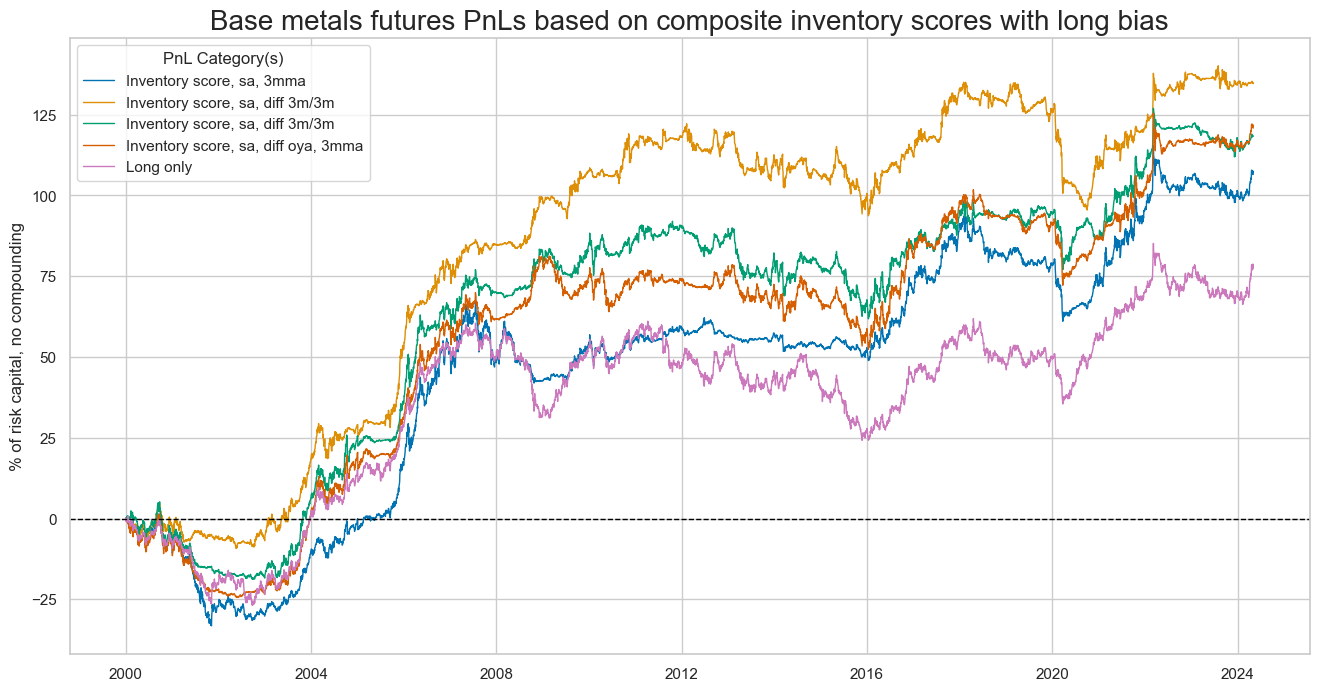

In [59]:
dix = dict_dcs

start = dix["start"]
cidx = dix["cidx"]
sigx = [riv for riv in dix['rivs'] if riv.startswith('ISCORE')]
naive_pnl = dix["pnls"]
type = "PZN1"
pnls = [s + "_" + type for s in sigx] + ["Long only"]

dict_labels = {
    f"ISCORE_SA_3MMA_CZS_{type}": "Inventory score, sa, 3mma",
    f"ISCORE_SA_D3M3ML3_CZS_{type}": "Inventory score, sa, diff 3m/3m",
    f"ISCORE_SA_D6M6ML6_CZS_{type}": "Inventory score, sa, diff 3m/3m",
    f"ISCORE_SA_3MMA_D1M1ML12_CZS_{type}": "Inventory score, sa, diff oya, 3mma",
    f"Long only": "Long only",
}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Base metals futures PnLs based on composite inventory scores with long bias",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The [`evaluate_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#evaluate-pnls) method displays standard performance metrics of long-biased naive PnLs using all created signals for the directional contract strategy.

In [60]:
dix = dict_dcs

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + "_PZN1" for s in sigx] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)


In [61]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                      
ISCORE_SA_3MMA_CZS_PZN1                      4.378842              10.0   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN1               4.9678              10.0   
ISCORE_SA_CZS_PZN1                           5.667855              10.0   
ISCORE_SA_D3M3ML3_CZS_PZN1                   5.533445              10.0   
ISCORE_SA_D6M6ML6_CZS_PZN1                   4.867836              10.0   
Long only                                    3.175902              10.0   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN1        2.885408              10.0   
XINVSCORELME_SA_3MMA_ZN_PZN1                 3.498199              10.0   
XINVSCORELME_SA_CZS_PZN1                     3.792235              10.0   
XINVSCORELME_SA_D3M3ML3_ZN_PZN1              4.252947              10.0   
XINVSCORELME_SA_D6M6ML6_ZN_PZN1              3.046476              10.0   

                                      Sharpe Ratio Sortino Ratio  \
xcat                                                               
ISCORE_SA_3MMA_CZS_PZN1                   0.437884      0.630755   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN1           0.49678      0.726588   
ISCORE_SA_CZS_PZN1                        0.566785      0.828434   
ISCORE_SA_D3M3ML3_CZS_PZN1                0.553344      0.804389   
ISCORE_SA_D6M6ML6_CZS_PZN1                0.486784      0.707427   
Long only                                  0.31759      0.454225   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN1     0.288541      0.423458   
XINVSCORELME_SA_3MMA_ZN_PZN1               0.34982      0.502775   
XINVSCORELME_SA_CZS_PZN1                  0.379224      0.555532   
XINVSCORELME_SA_D3M3ML3_ZN_PZN1           0.425295      0.628048   
XINVSCORELME_SA_D6M6ML6_ZN_PZN1           0.304648      0.449479   

                                      Max 21-day draw Max 6-month draw  \
xcat                                                                     
ISCORE_SA_3MMA_CZS_PZN1                    -14.169429       -20.544096   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN1           -13.224399       -20.982206   
ISCORE_SA_CZS_PZN1                          -15.79689       -24.387931   
ISCORE_SA_D3M3ML3_CZS_PZN1                 -17.013652       -27.882576   
ISCORE_SA_D6M6ML6_CZS_PZN1                 -13.294511       -18.760919   
Long only                                   -12.89172       -21.260647   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN1      -11.087272       -19.361661   
XINVSCORELME_SA_3MMA_ZN_PZN1               -13.887967        -23.26314   
XINVSCORELME_SA_CZS_PZN1                   -11.697586       -21.129246   
XINVSCORELME_SA_D3M3ML3_ZN_PZN1            -11.602292       -18.843979   
XINVSCORELME_SA_D6M6ML6_ZN_PZN1            -10.923883       -20.690585   

                                      GLB_DRBXR_NSA correl  \
xcat                                                         
ISCORE_SA_3MMA_CZS_PZN1                           0.253243   
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN1                  0.227473   
ISCORE_SA_CZS_PZN1                                0.228618   
ISCORE_SA_D3M3ML3_CZS_PZN1                        0.223393   
ISCORE_SA_D6M6ML6_CZS_PZN1                        0.235829   
Long only                                          0.37178   
XINVSCORELME_SA_3MMA_D1M1ML12_ZN_PZN1             0.230835   
XINVSCORELME_SA_3MMA_ZN_PZN1                      0.250118   
XINVSCORELME_SA_CZS_PZN1                          0.238375   
XINVSCORELME_SA_D3M3ML3_ZN_PZN1                   0.252417   
XINVSCORELME_SA_D6M6ML6_ZN_PZN1                   0.239144   

                                      GEQ_DRBXR_NSA correl Traded Months  
xcat                                                                      
ISCORE_SA_3MMA_CZS_PZN1                           0.230914           293  
ISCORE_SA_3MMA_D1M1ML12_CZS_PZN1                  0.203872           293  
ISCORE_SA_CZS_PZN1                                0.204745           293  
ISCORE_SA_D3M3ML3_CZS_PZN1      